In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
%config InlineBackend.figure_format = 'retina'


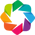

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import loren_frank_data_processing as lfdp
import spectral_connectivity
import ripple_detection
import replay_classification

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
epoch_key = ('JZ1', 6, 2)

In [4]:
from src.parameters import ANIMALS

tetrode_info = lfdp.make_tetrode_dataframe(ANIMALS).xs(epoch_key, drop_level=False)
tetrode_info = tetrode_info.loc[tetrode_info.area != 'ref']

In [5]:
from src.analysis import detect_epoch_ripples

ripple_times = detect_epoch_ripples(epoch_key, ANIMALS)

INFO:src.analysis:Detecting ripples


## Ripple-locked Power

In [6]:
LFPs = pd.concat(
    [lfdp.get_LFP_dataframe(tetrode_key, ANIMALS)
     for tetrode_key in tetrode_info.index], axis=1, keys=tetrode_info.tetrode_id
).astype(float).resample('1ms').mean().dropna()


In [7]:
window_offset = (-0.5, 0.5)
sampling_frequency = 1000

ripple_locked_LFPs = lfdp.reshape_to_segments(LFPs, ripple_times, window_offset=window_offset)
ripple_locked_LFPs = (ripple_locked_LFPs.to_xarray()
                      .to_array(dim='signals').transpose('time', 'ripple_number', 'signals'))

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=1,
           time_window_duration=0.25, time_window_step=0.25,
           detrend_type='constant', start_time=-0.5, n_tapers=1)
INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=1,
           time_window_duration=0.25, time_window_step=0.25,
           detrend_type='constant', start_time=-0.5, n_tapers=1)


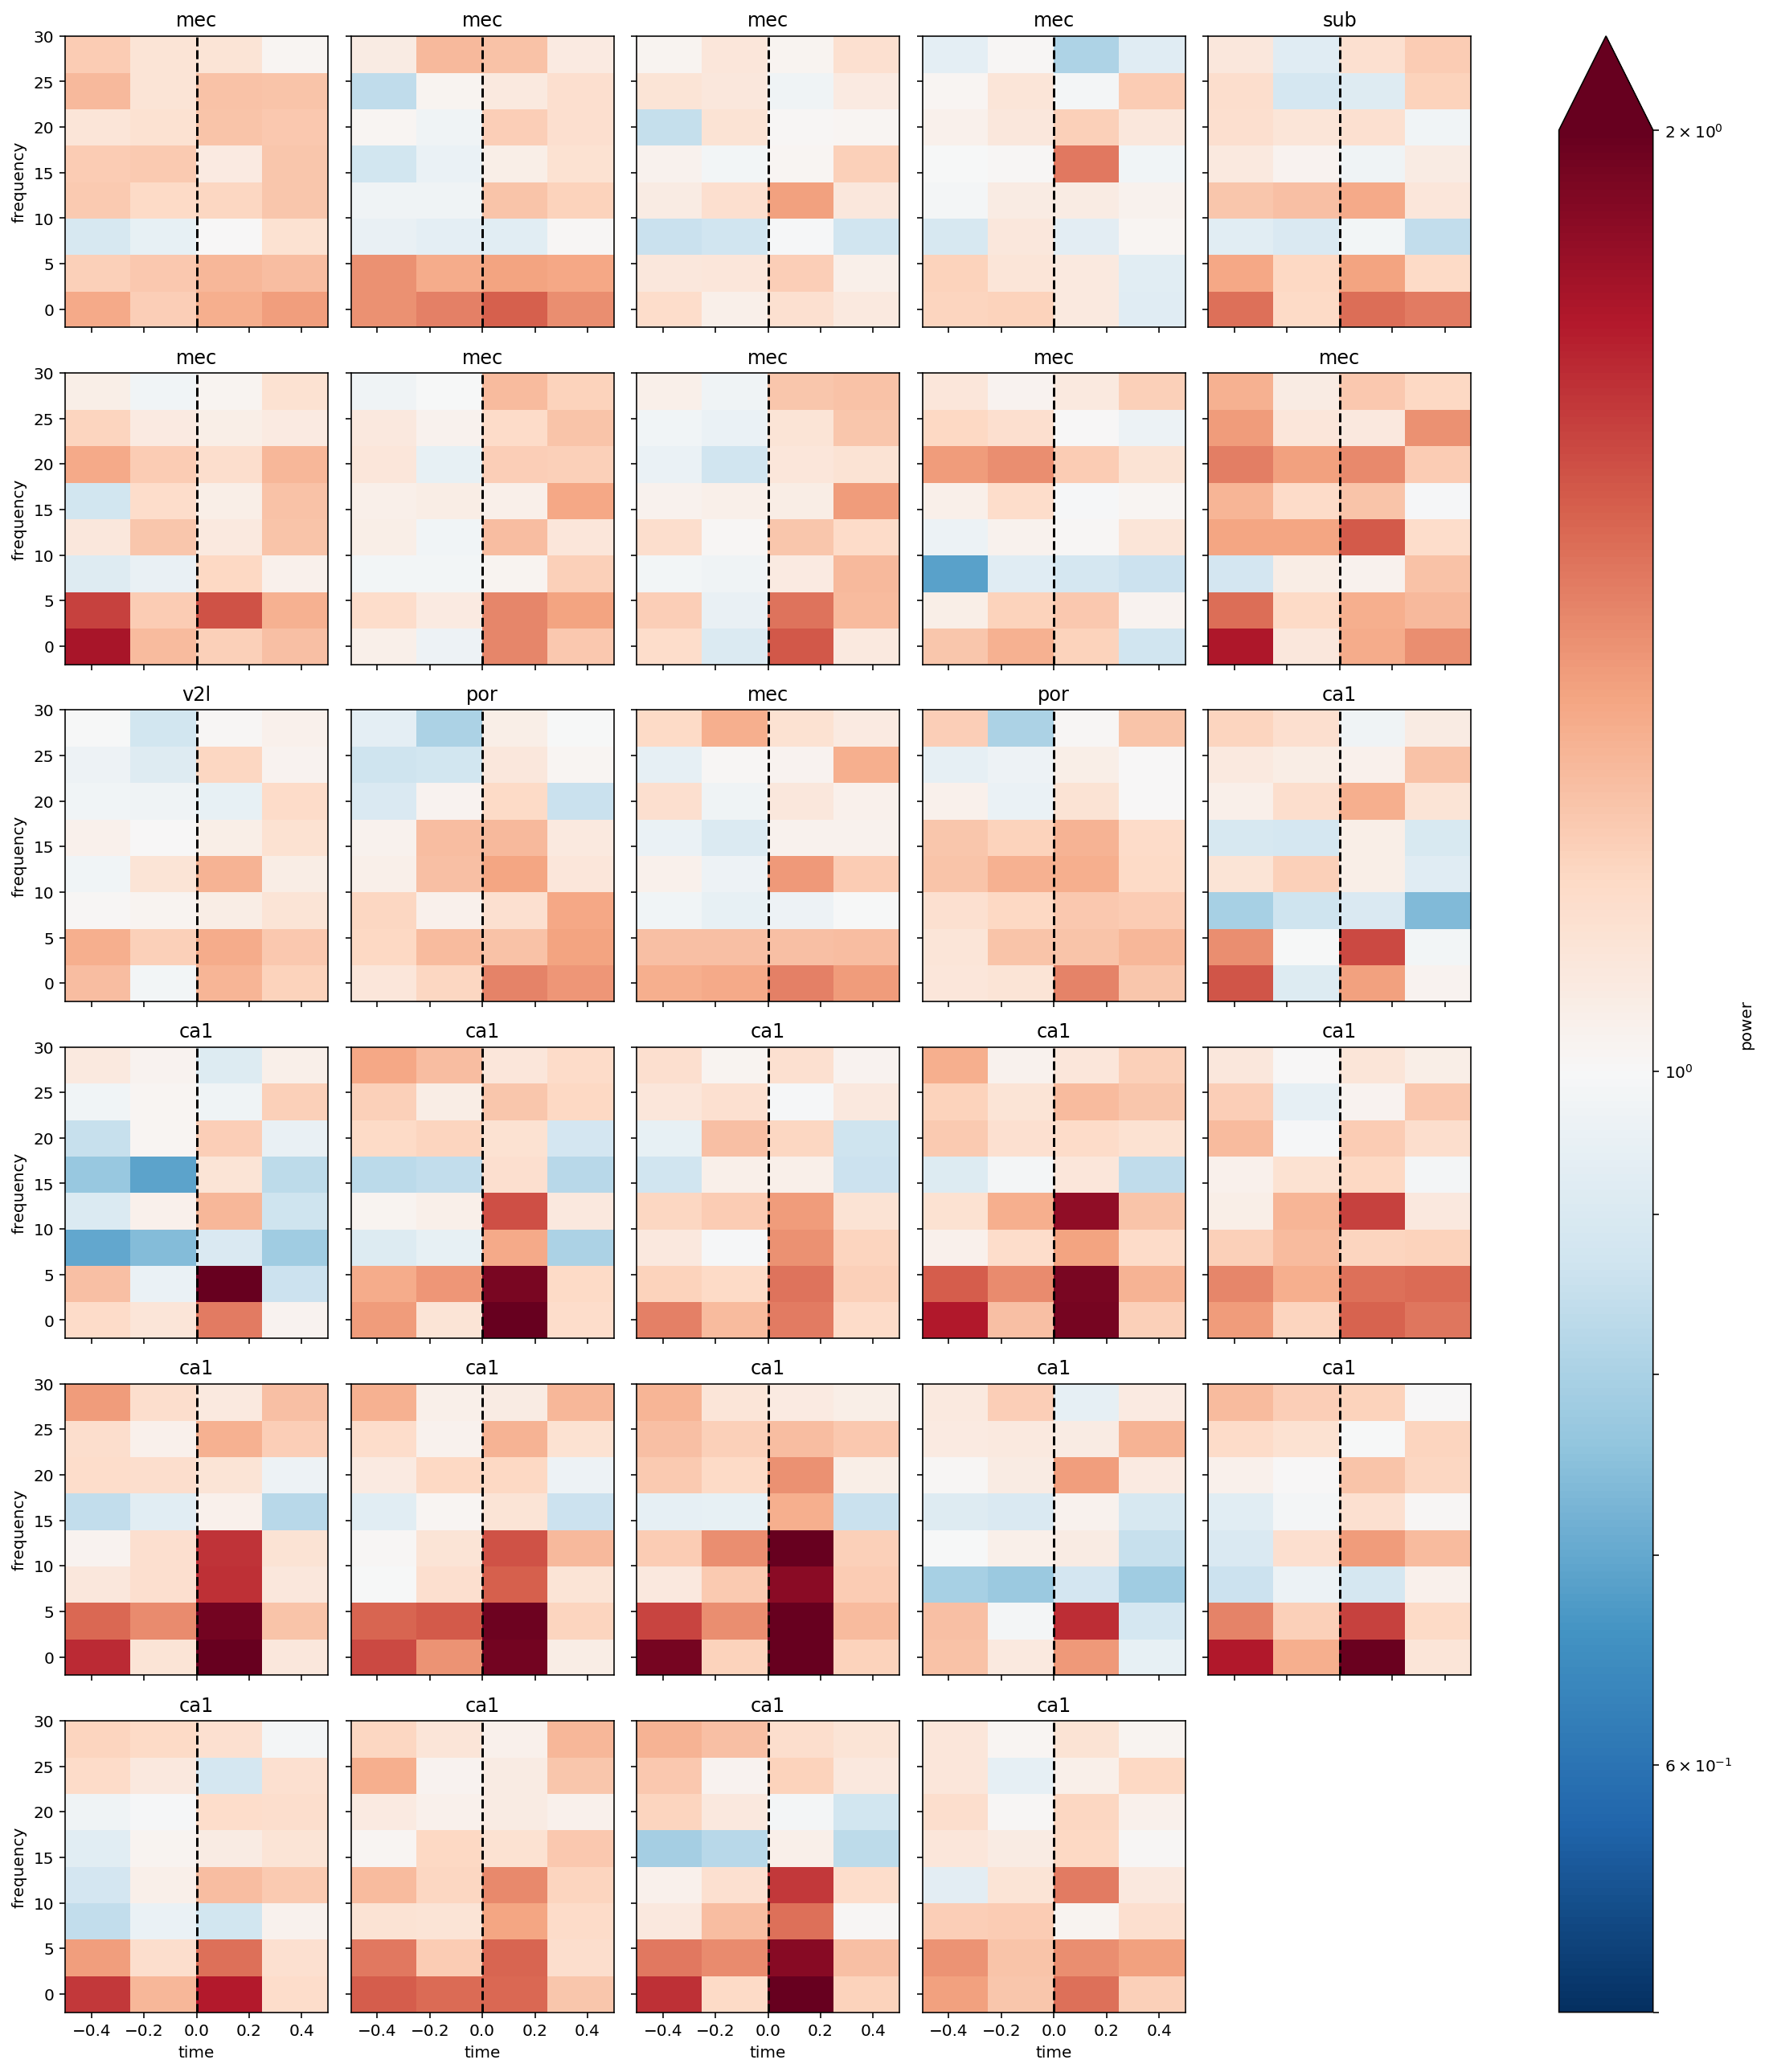

In [8]:
from matplotlib.colors import LogNorm

_4Hz_Res = dict(
    sampling_frequency=sampling_frequency,
    time_window_duration=0.250,
    time_window_step=0.250,
    time_halfbandwidth_product=1,
)


def plot_power(ripple_locked_LFPs, LFPs, window_offset, multitaper_params, frequency,
               tetrode_info, vmin=0.5, vmax=2):
    
    m = spectral_connectivity.Multitaper(
        ripple_locked_LFPs.values, **multitaper_params, start_time=window_offset[0])
    c = spectral_connectivity.Connectivity.from_multitaper(m)
    ripple_locked_power = xr.DataArray(
        c.power(), dims=('time', 'frequency', 'signals'),
        coords=dict(time=c.time + np.diff(c.time)[0] / 2, frequency=c.frequencies), name='power')
    m = spectral_connectivity.Multitaper(
        LFPs.values, **multitaper_params, start_time=window_offset[0])
    c = spectral_connectivity.Connectivity.from_multitaper(m)
    power = xr.DataArray(
        c.power(), dims=('time', 'frequency', 'signals'),
        coords=dict(time=c.time, frequency=c.frequencies), name='power').mean('time')

    p = (ripple_locked_power / power).sel(frequency=frequency).plot(
        x='time', y='frequency', col='signals', col_wrap=5,
        center=0, norm=LogNorm(vmin=vmin, vmax=vmax), vmin=vmin,
        vmax=vmax, cmap='RdBu_r')
    for ind, ax in enumerate(p.axes.flat):
        try:
            ax.set_title(tetrode_info.iloc[ind].area)
            ax.axvline(0, color='black', linestyle='--')
        except IndexError:
            pass
    
plot_power(ripple_locked_LFPs, LFPs, window_offset, _4Hz_Res, slice(0, 30), tetrode_info)

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=1,
           time_window_duration=0.25, time_window_step=0.25,
           detrend_type='constant', start_time=-0.5, n_tapers=1)
INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=1,
           time_window_duration=0.25, time_window_step=0.25,
           detrend_type='constant', start_time=-0.5, n_tapers=1)


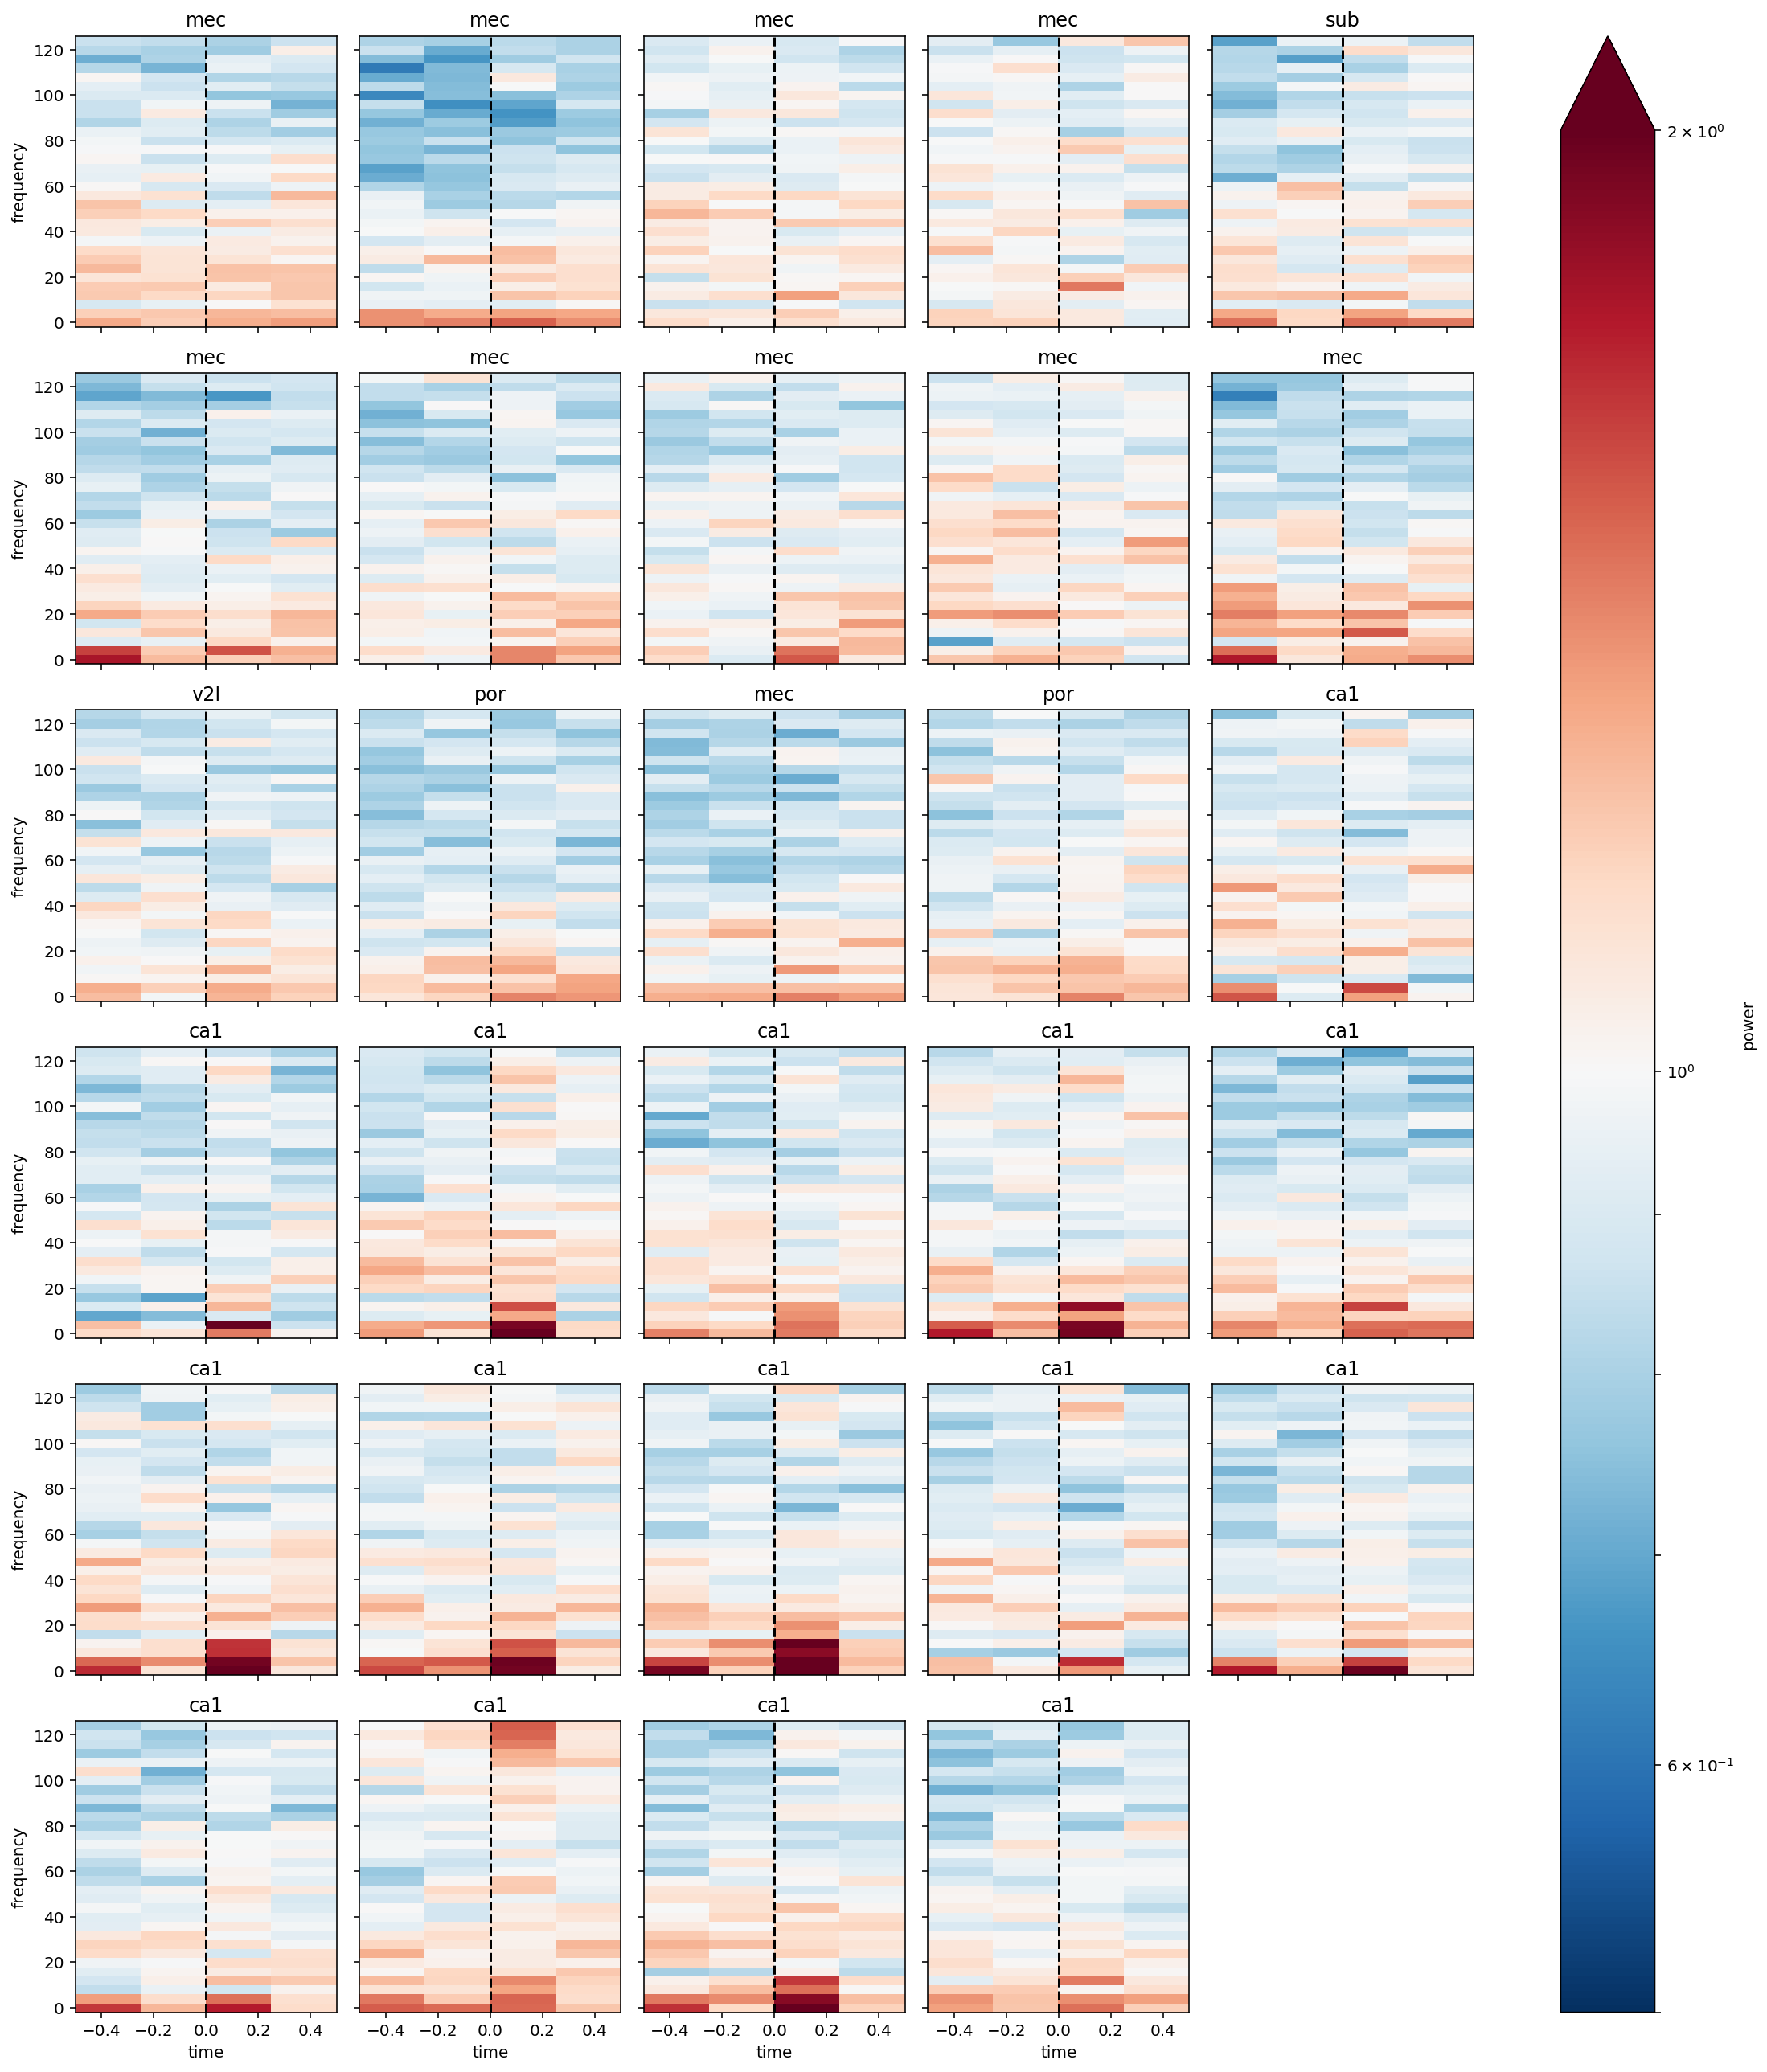

In [9]:
plot_power(ripple_locked_LFPs, LFPs, window_offset, _4Hz_Res, slice(0, 125), tetrode_info)

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=1,
           time_window_duration=0.5, time_window_step=0.5,
           detrend_type='constant', start_time=-0.5, n_tapers=1)
INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=1,
           time_window_duration=0.5, time_window_step=0.5,
           detrend_type='constant', start_time=-0.5, n_tapers=1)


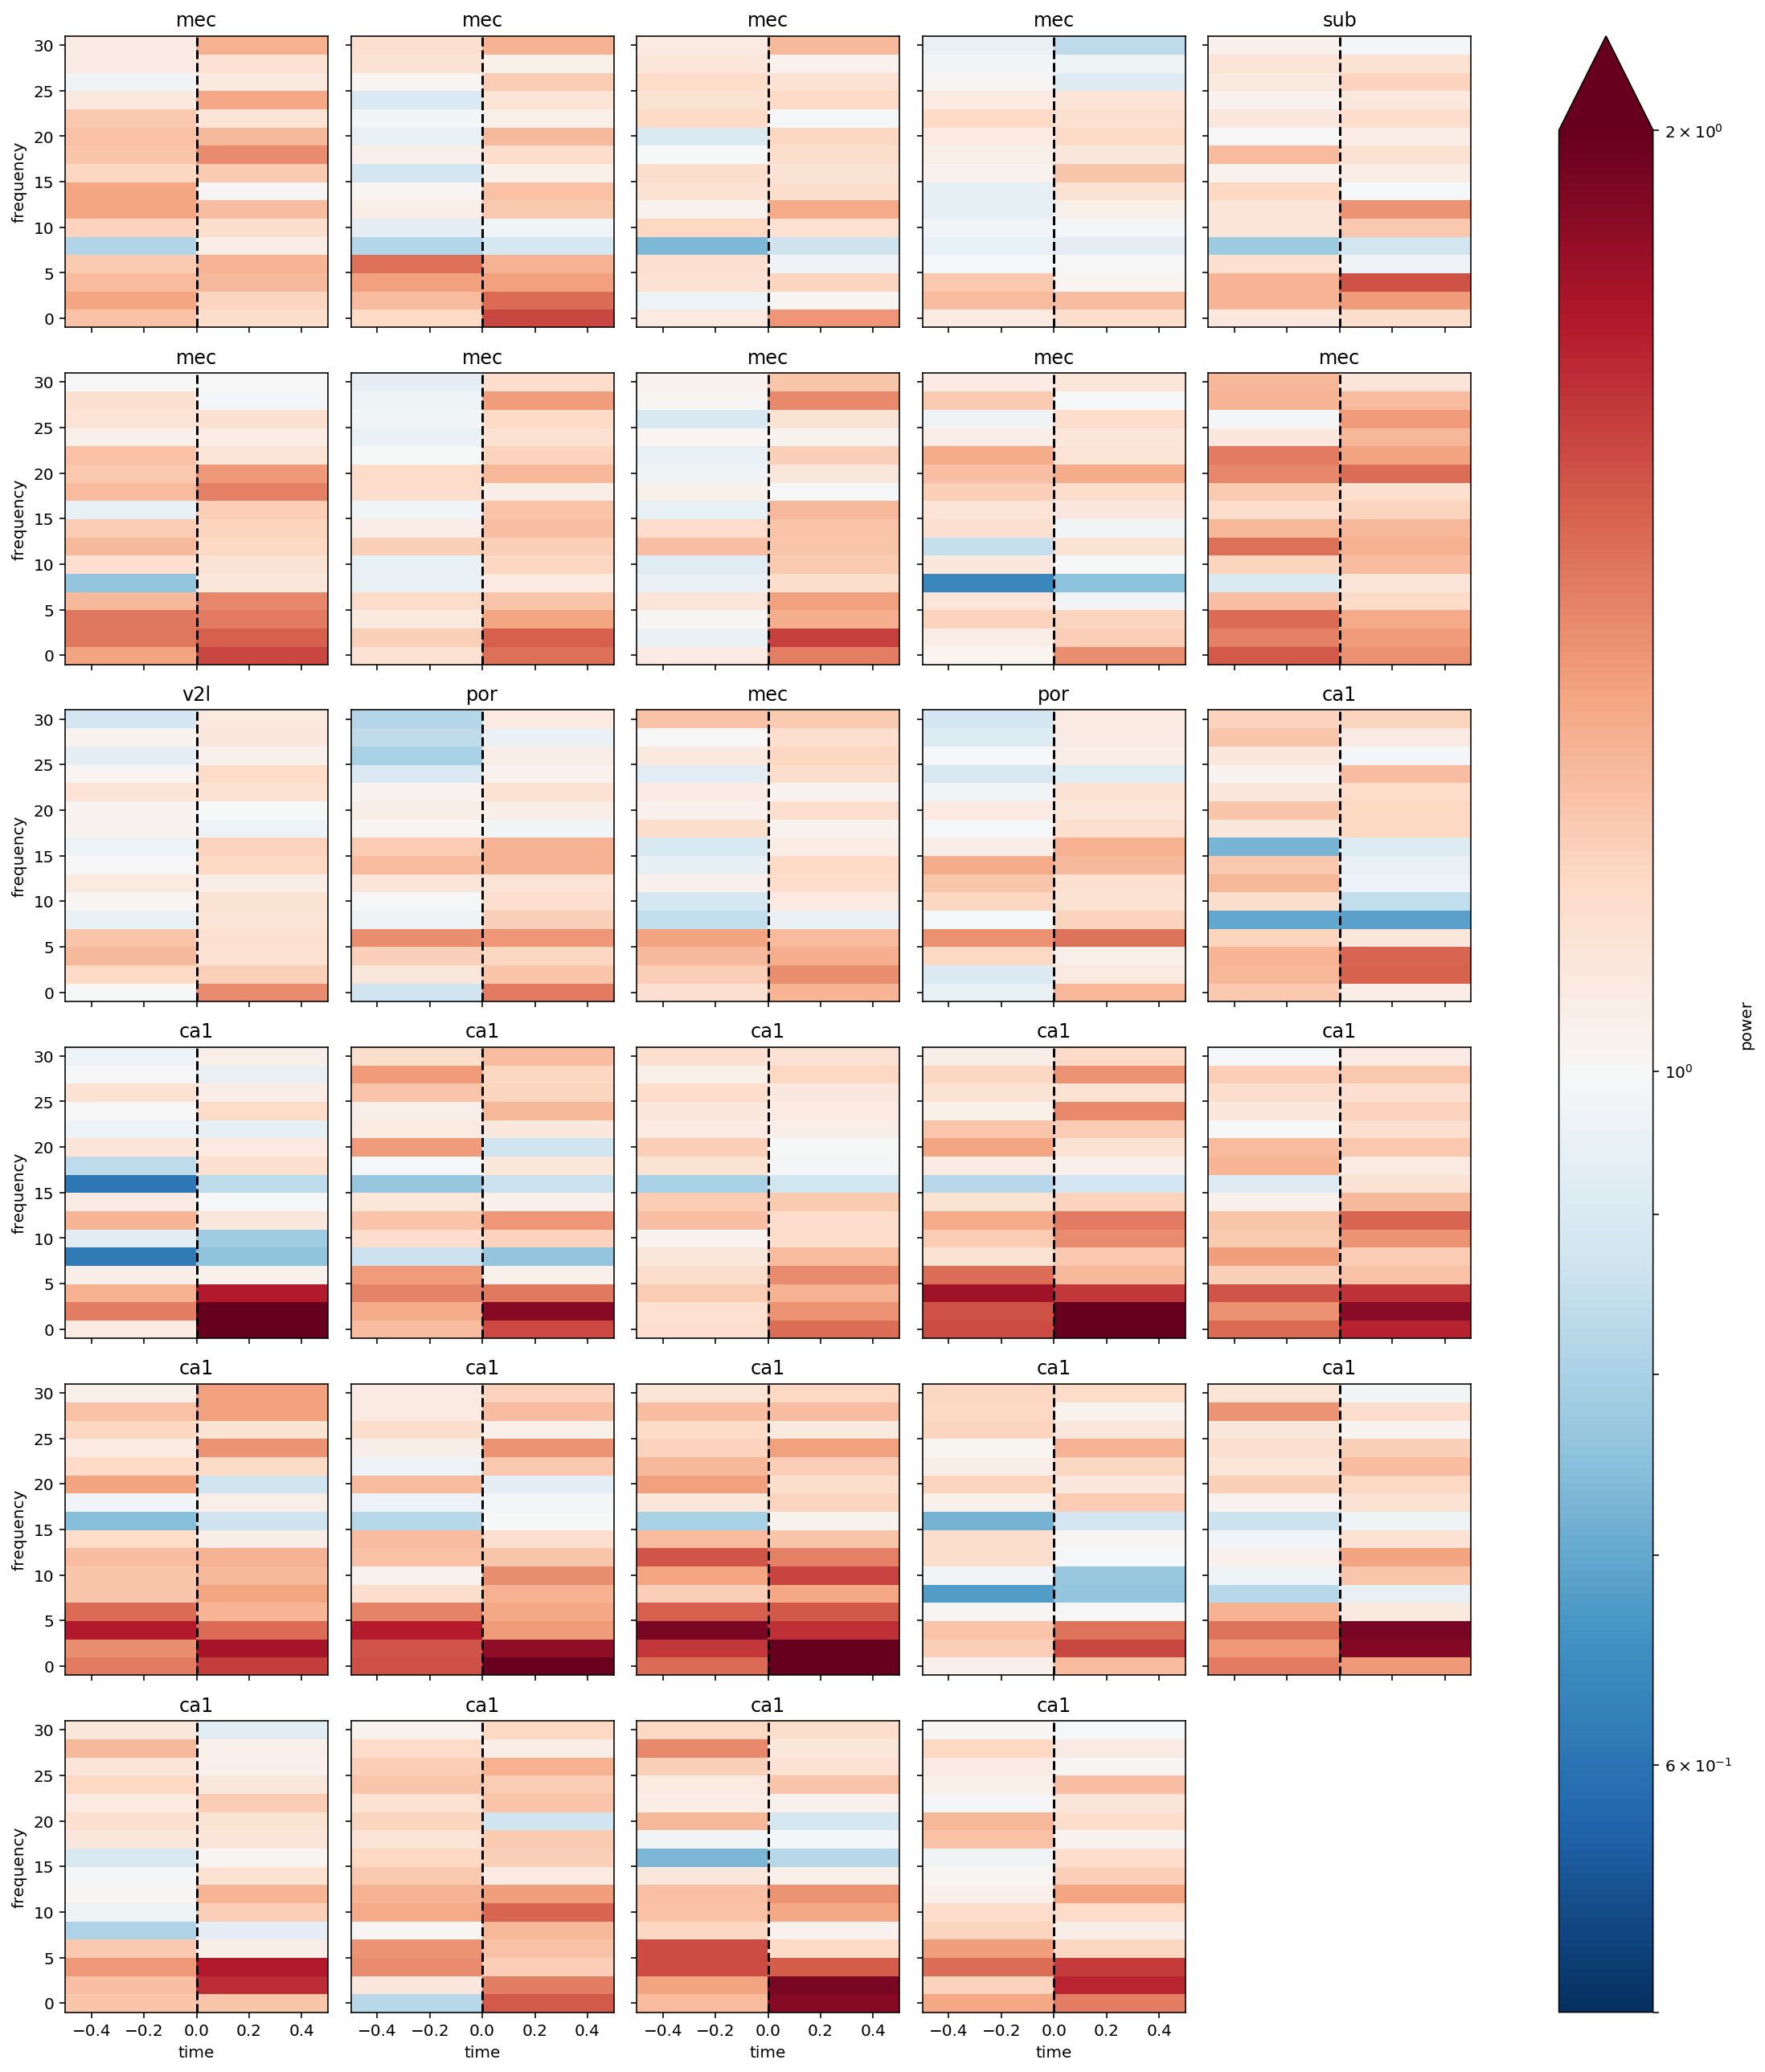

In [10]:
_2Hz_Res = dict(
    sampling_frequency=sampling_frequency,
    time_window_duration=0.500,
    time_window_step=0.500,
    time_halfbandwidth_product=1,
)

plot_power(ripple_locked_LFPs, LFPs, window_offset, _2Hz_Res, slice(0, 30), tetrode_info)

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=1,
           time_window_duration=0.1, time_window_step=0.1,
           detrend_type='constant', start_time=-0.5, n_tapers=1)
INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=1,
           time_window_duration=0.1, time_window_step=0.1,
           detrend_type='constant', start_time=-0.5, n_tapers=1)


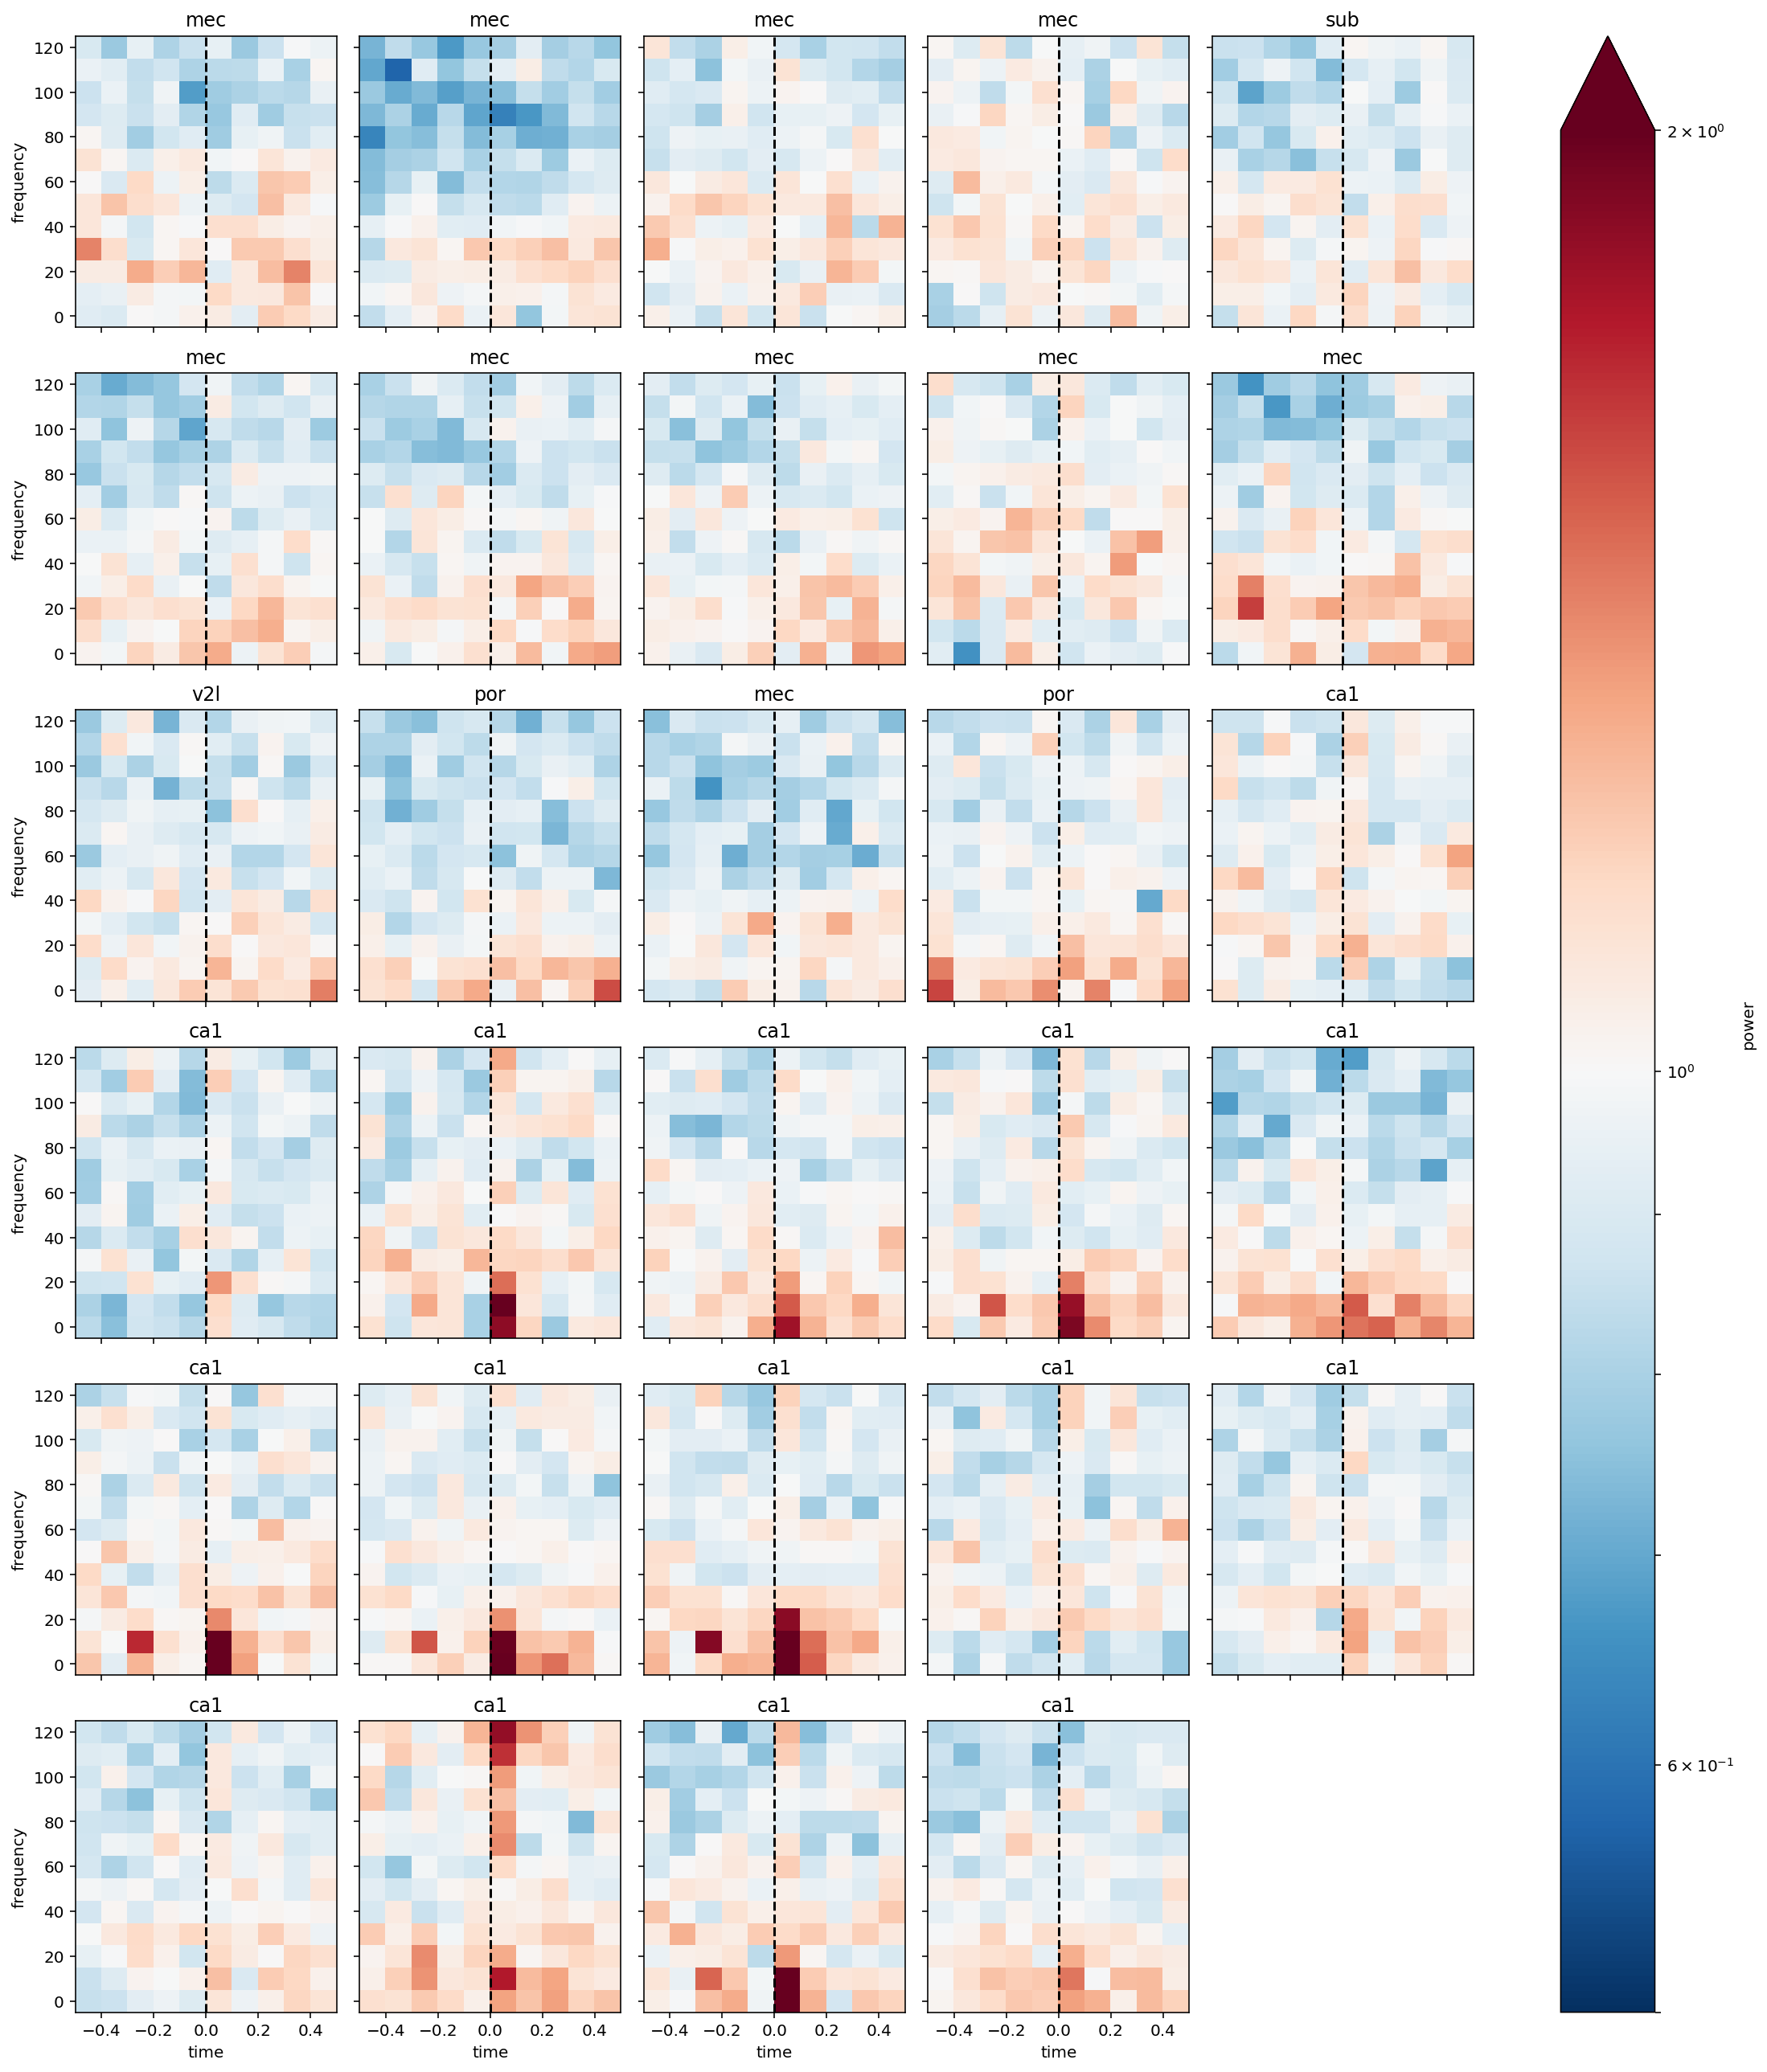

In [11]:
_10Hz_Res = dict(
    sampling_frequency=sampling_frequency,
    time_window_duration=0.100,
    time_window_step=0.100,
    time_halfbandwidth_product=1,
)

plot_power(ripple_locked_LFPs, LFPs, window_offset, _10Hz_Res, slice(0, 125), tetrode_info)

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=3,
           time_window_duration=0.1, time_window_step=0.1,
           detrend_type='constant', start_time=-0.5, n_tapers=5)
INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=3,
           time_window_duration=0.1, time_window_step=0.1,
           detrend_type='constant', start_time=-0.5, n_tapers=5)


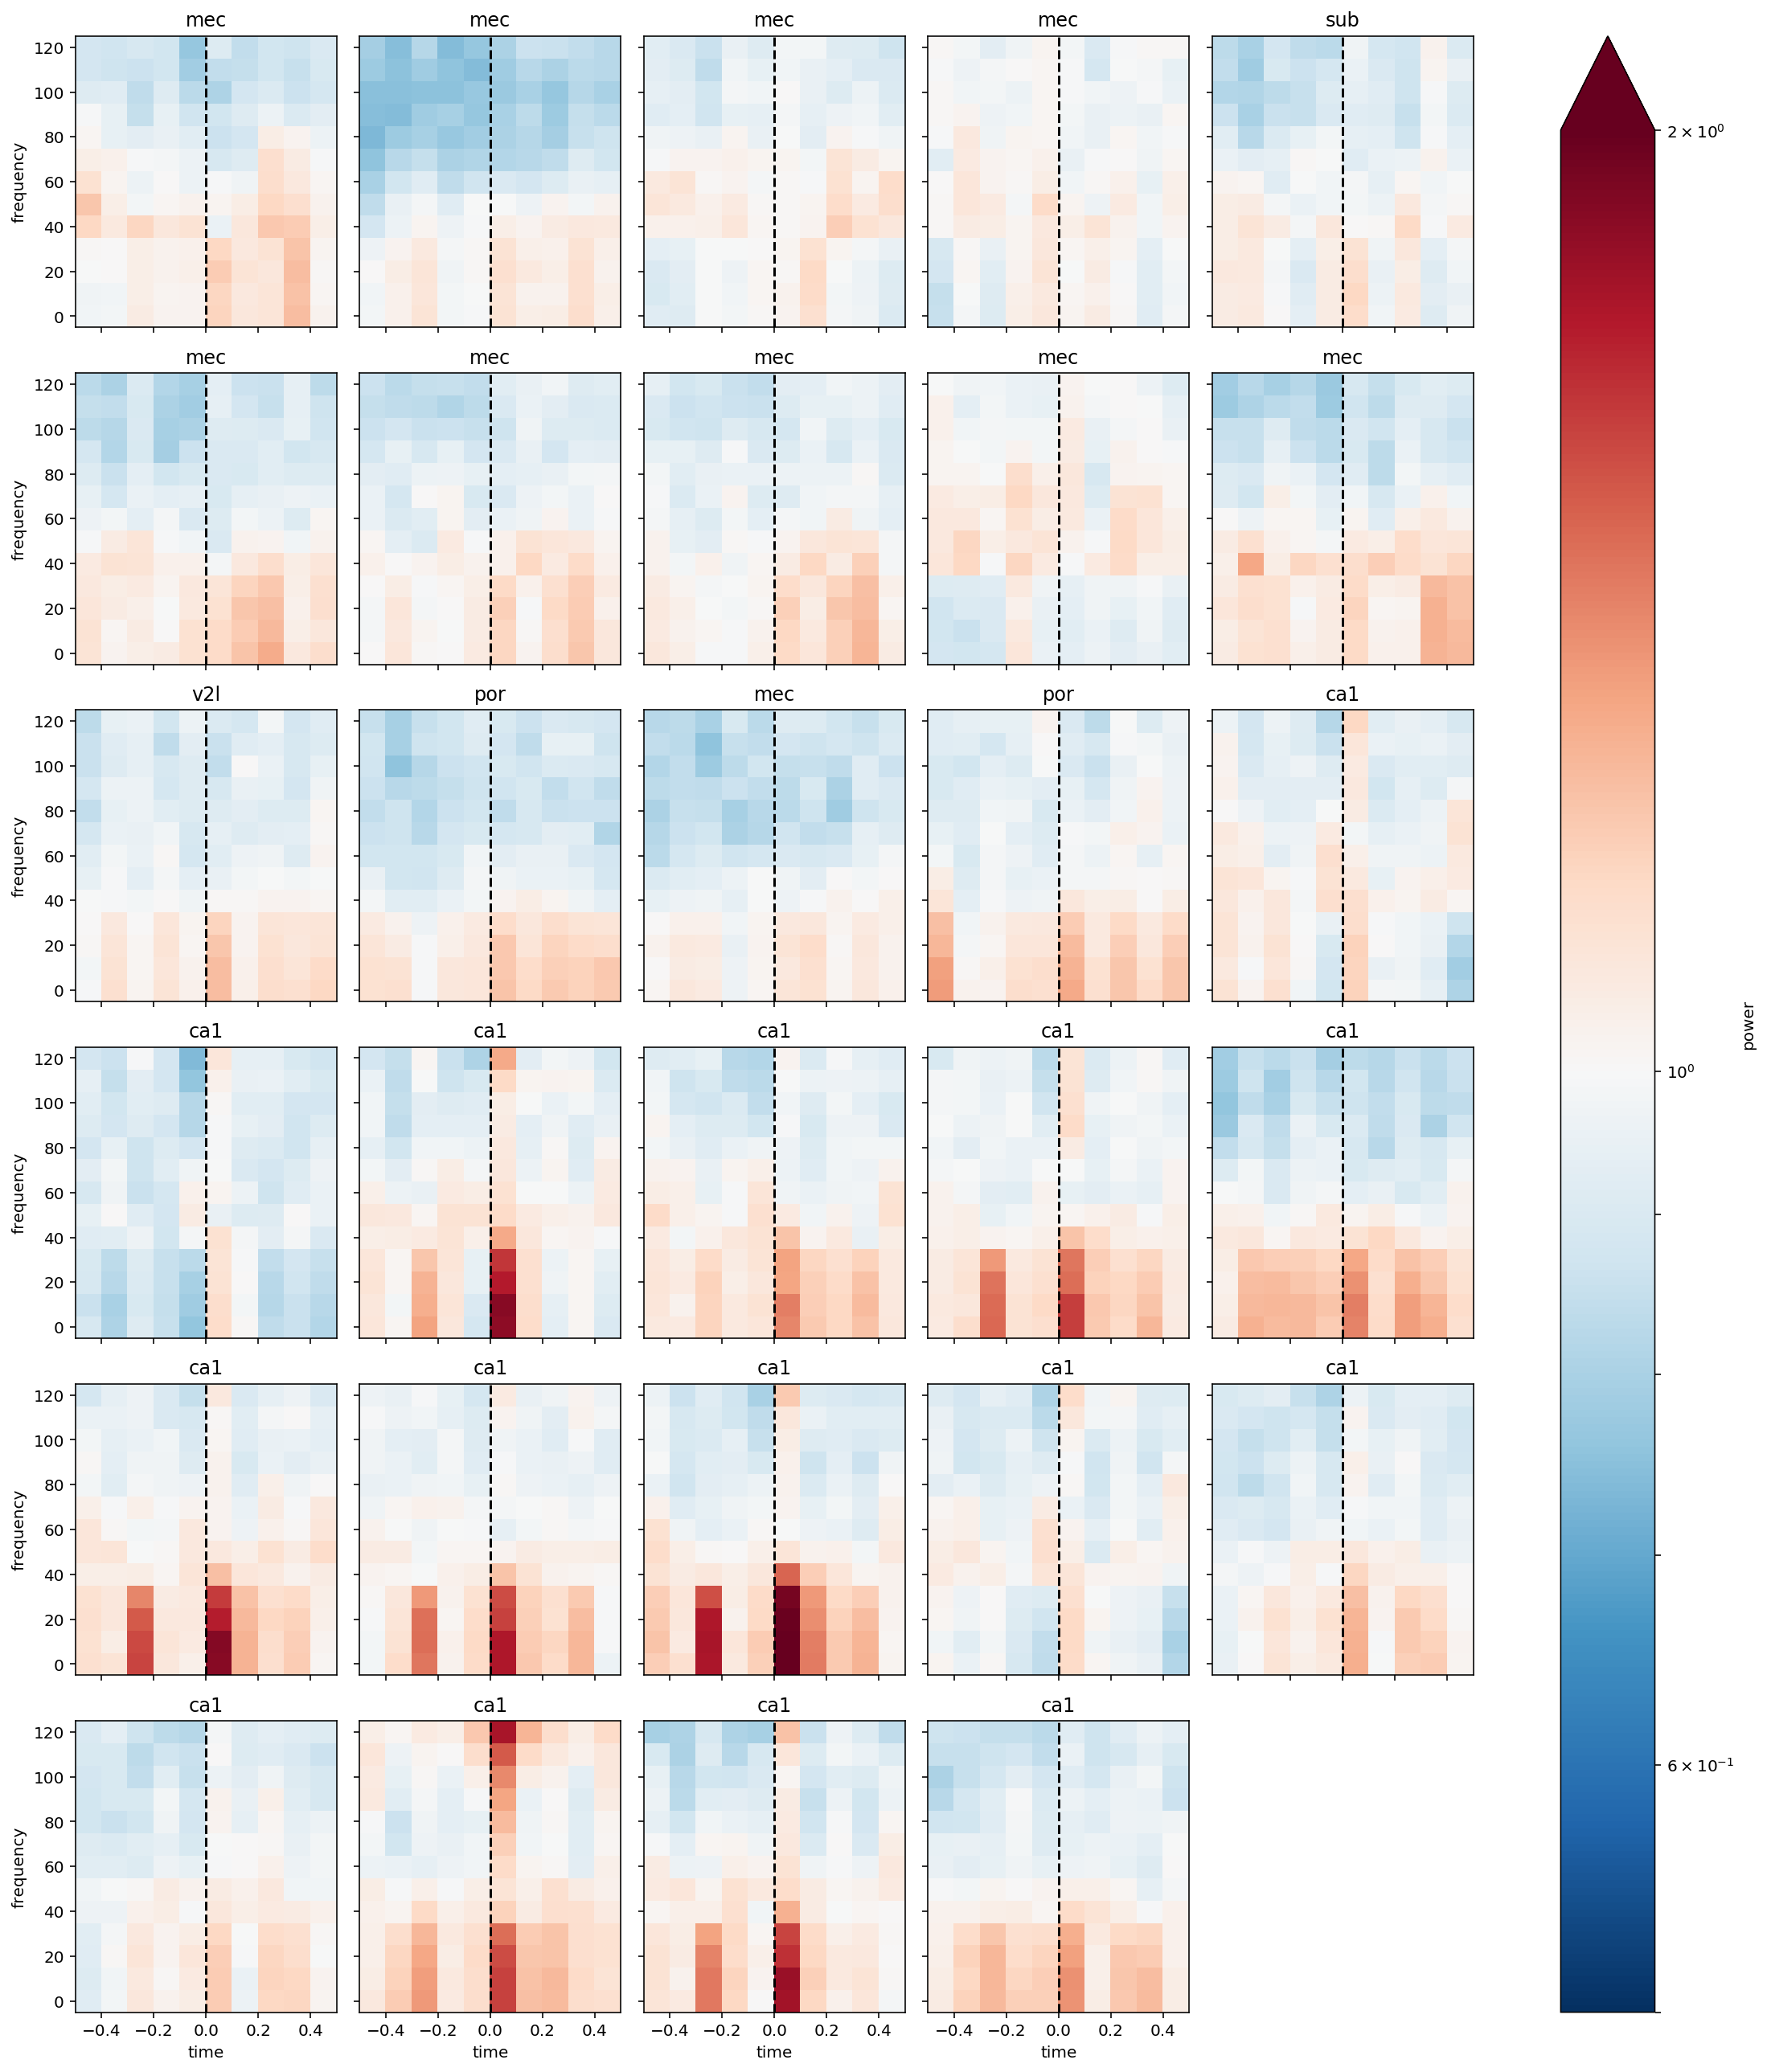

In [12]:
_20Hz_Res = dict(
    sampling_frequency=sampling_frequency,
    time_window_duration=0.100,
    time_window_step=0.100,
    time_halfbandwidth_product=3,
)

plot_power(ripple_locked_LFPs, LFPs, window_offset, _20Hz_Res, slice(0, 125), tetrode_info)

## Coherence

In [13]:
def plot_coherence(ripple_locked_LFPs, LFPs, window_offset, multitaper_params, frequency, tetrode_info):
    
    m = spectral_connectivity.Multitaper(
        ripple_locked_LFPs.values, **multitaper_params, start_time=window_offset[0])
    c = spectral_connectivity.Connectivity.from_multitaper(m)
    ripple_locked_coherence = xr.DataArray(
        c.coherence_magnitude(), dims=('time', 'frequency',  'signals1', 'signals2'),
        coords=dict(time=c.time + np.diff(c.time)[0] / 2, frequency=c.frequencies,
                    signals1=tetrode_info.tetrode_id, signals2=tetrode_info.tetrode_id))
    ripple_locked_coherence = ripple_locked_coherence.sel(
        signals1=tetrode_info.loc[tetrode_info.area == 'mec'].tetrode_id.tolist(),
        signals2=tetrode_info.loc[tetrode_info.area == 'ca1'].tetrode_id.tolist()
    )
    p = (ripple_locked_coherence - ripple_locked_coherence.isel(time=0)).sel(frequency=frequency).plot(
        x='time', y='frequency', col='signals1', row='signals2', col_wrap=5, center=0, cmap='RdBu_r')
    for ind, ax in enumerate(p.axes.ravel()):
        try:
            ax.axvline(0, color='black', linestyle='--')
        except IndexError:
            pass

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=1,
           time_window_duration=0.1, time_window_step=0.1,
           detrend_type='constant', start_time=-0.5, n_tapers=1)


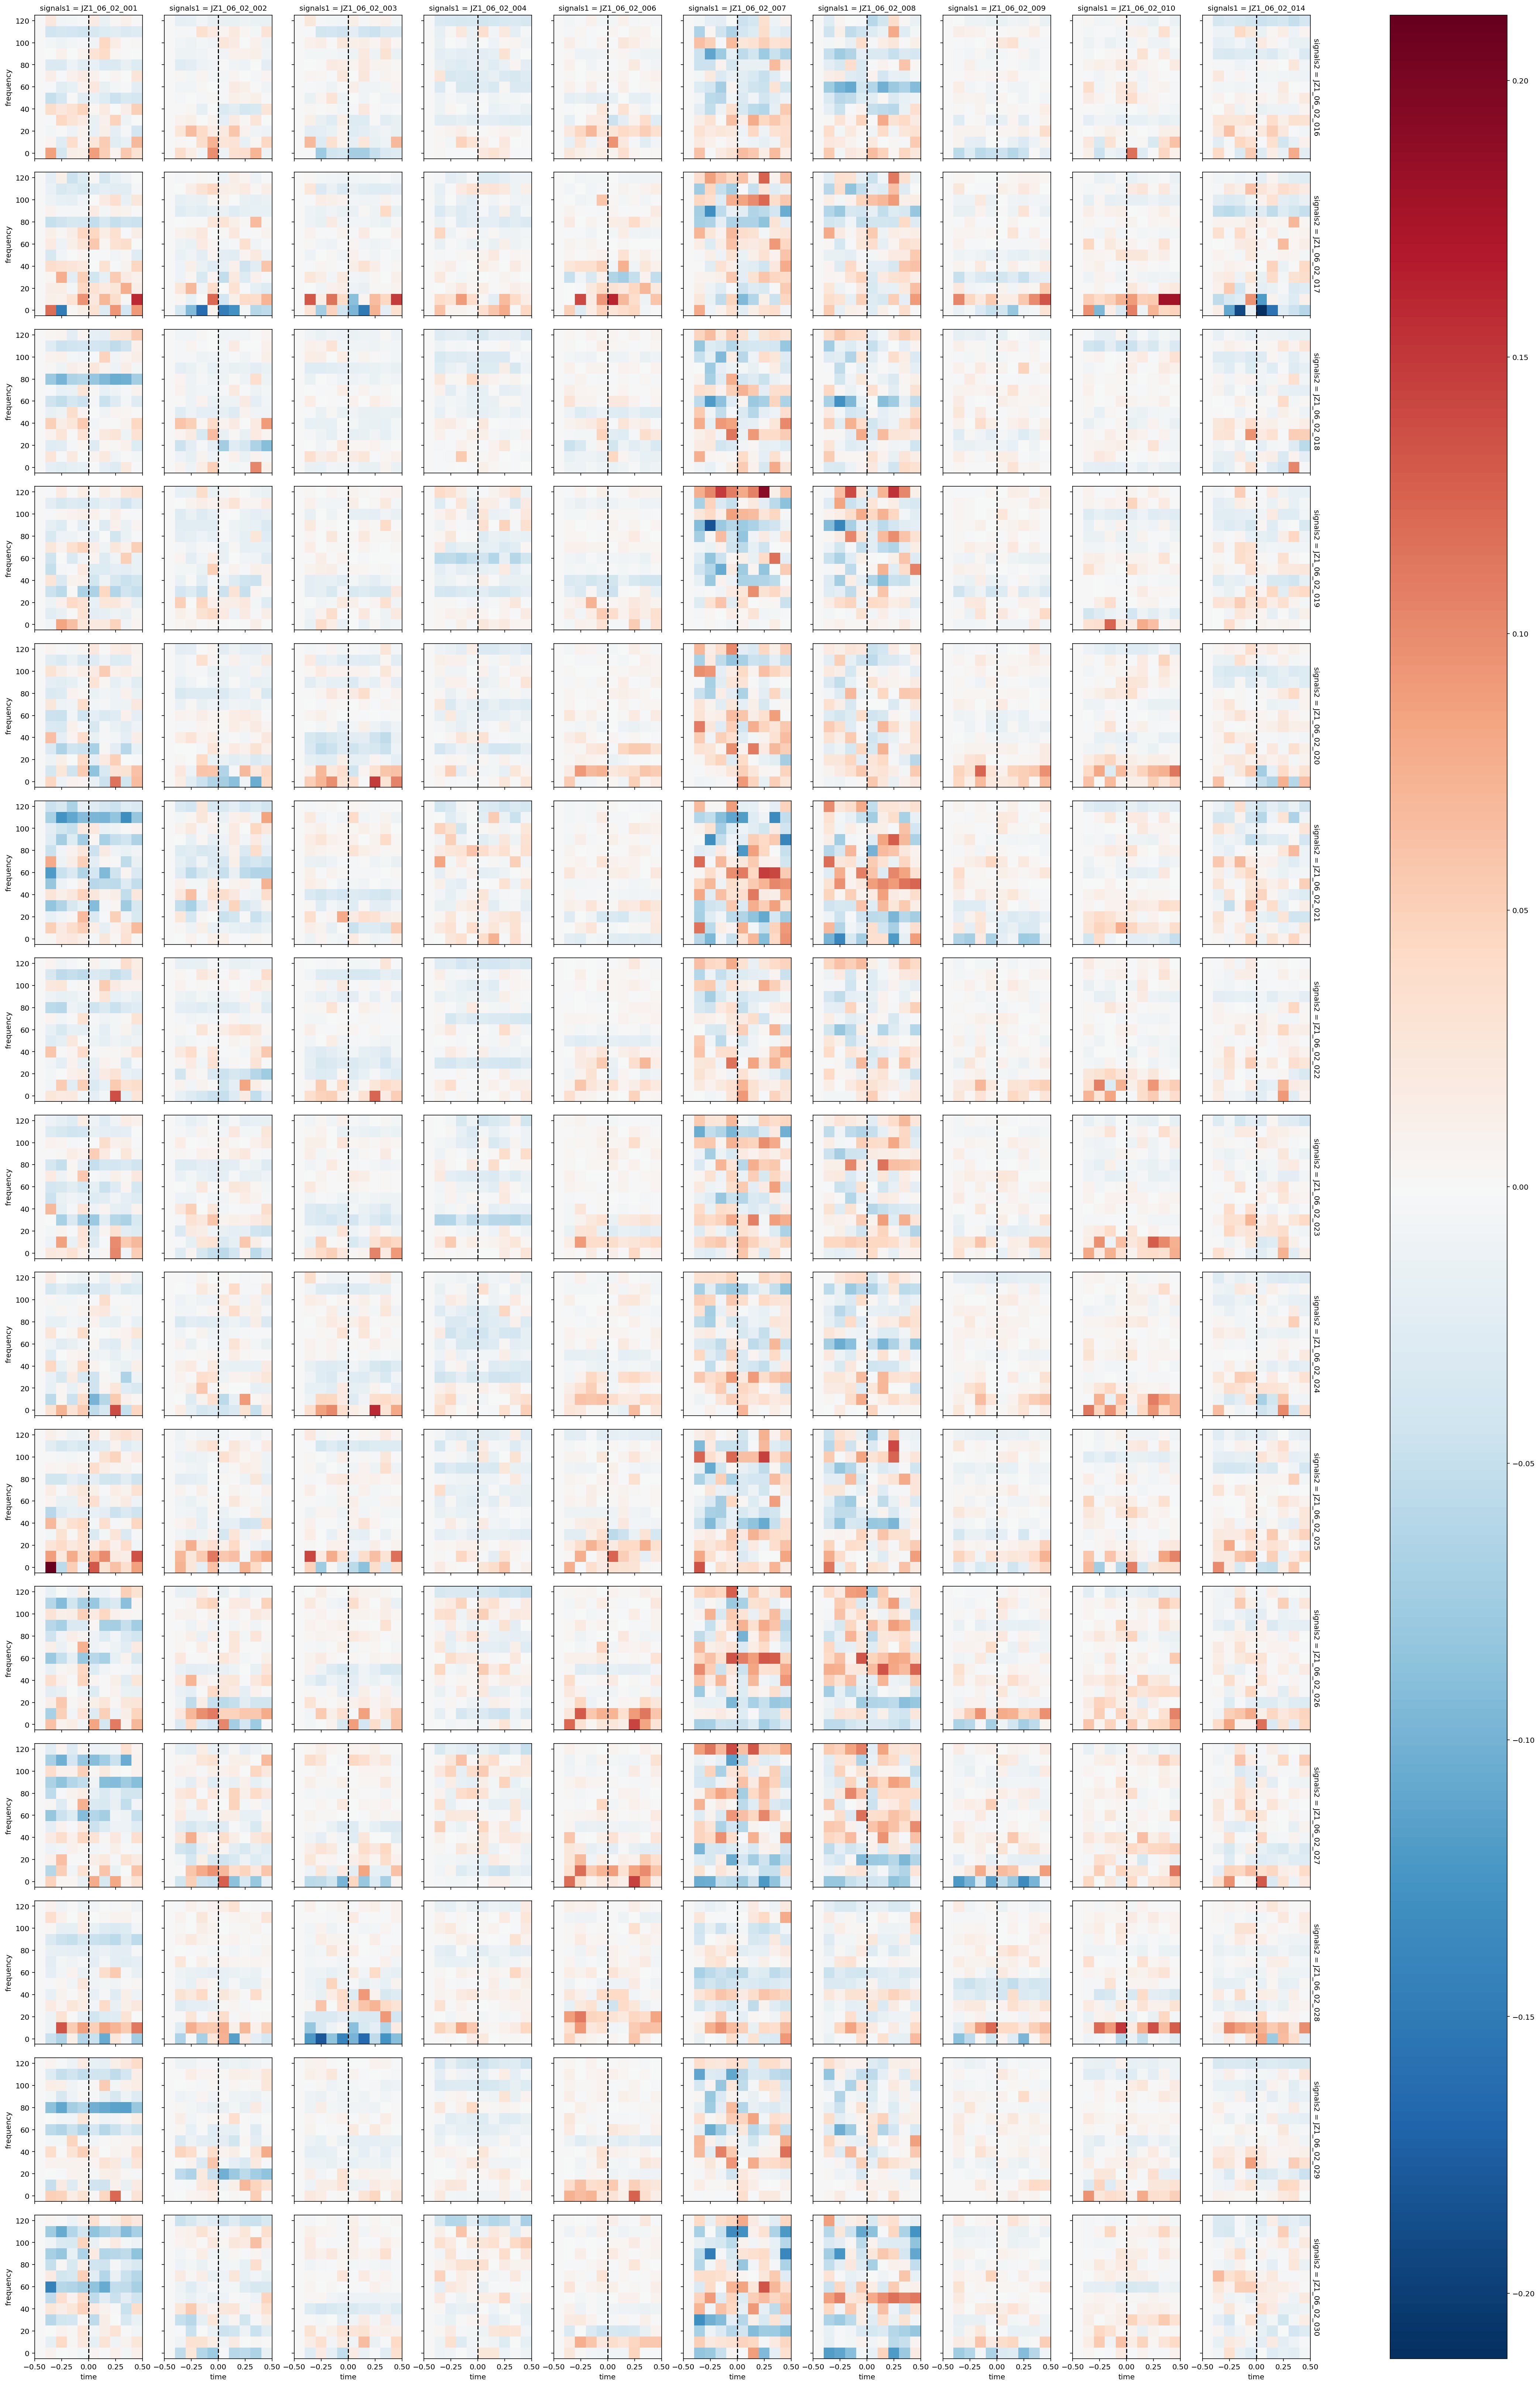

In [14]:
plot_coherence(ripple_locked_LFPs, LFPs, window_offset, _10Hz_Res, slice(0, 125), tetrode_info)

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=1,
           time_window_duration=0.25, time_window_step=0.25,
           detrend_type='constant', start_time=-0.5, n_tapers=1)


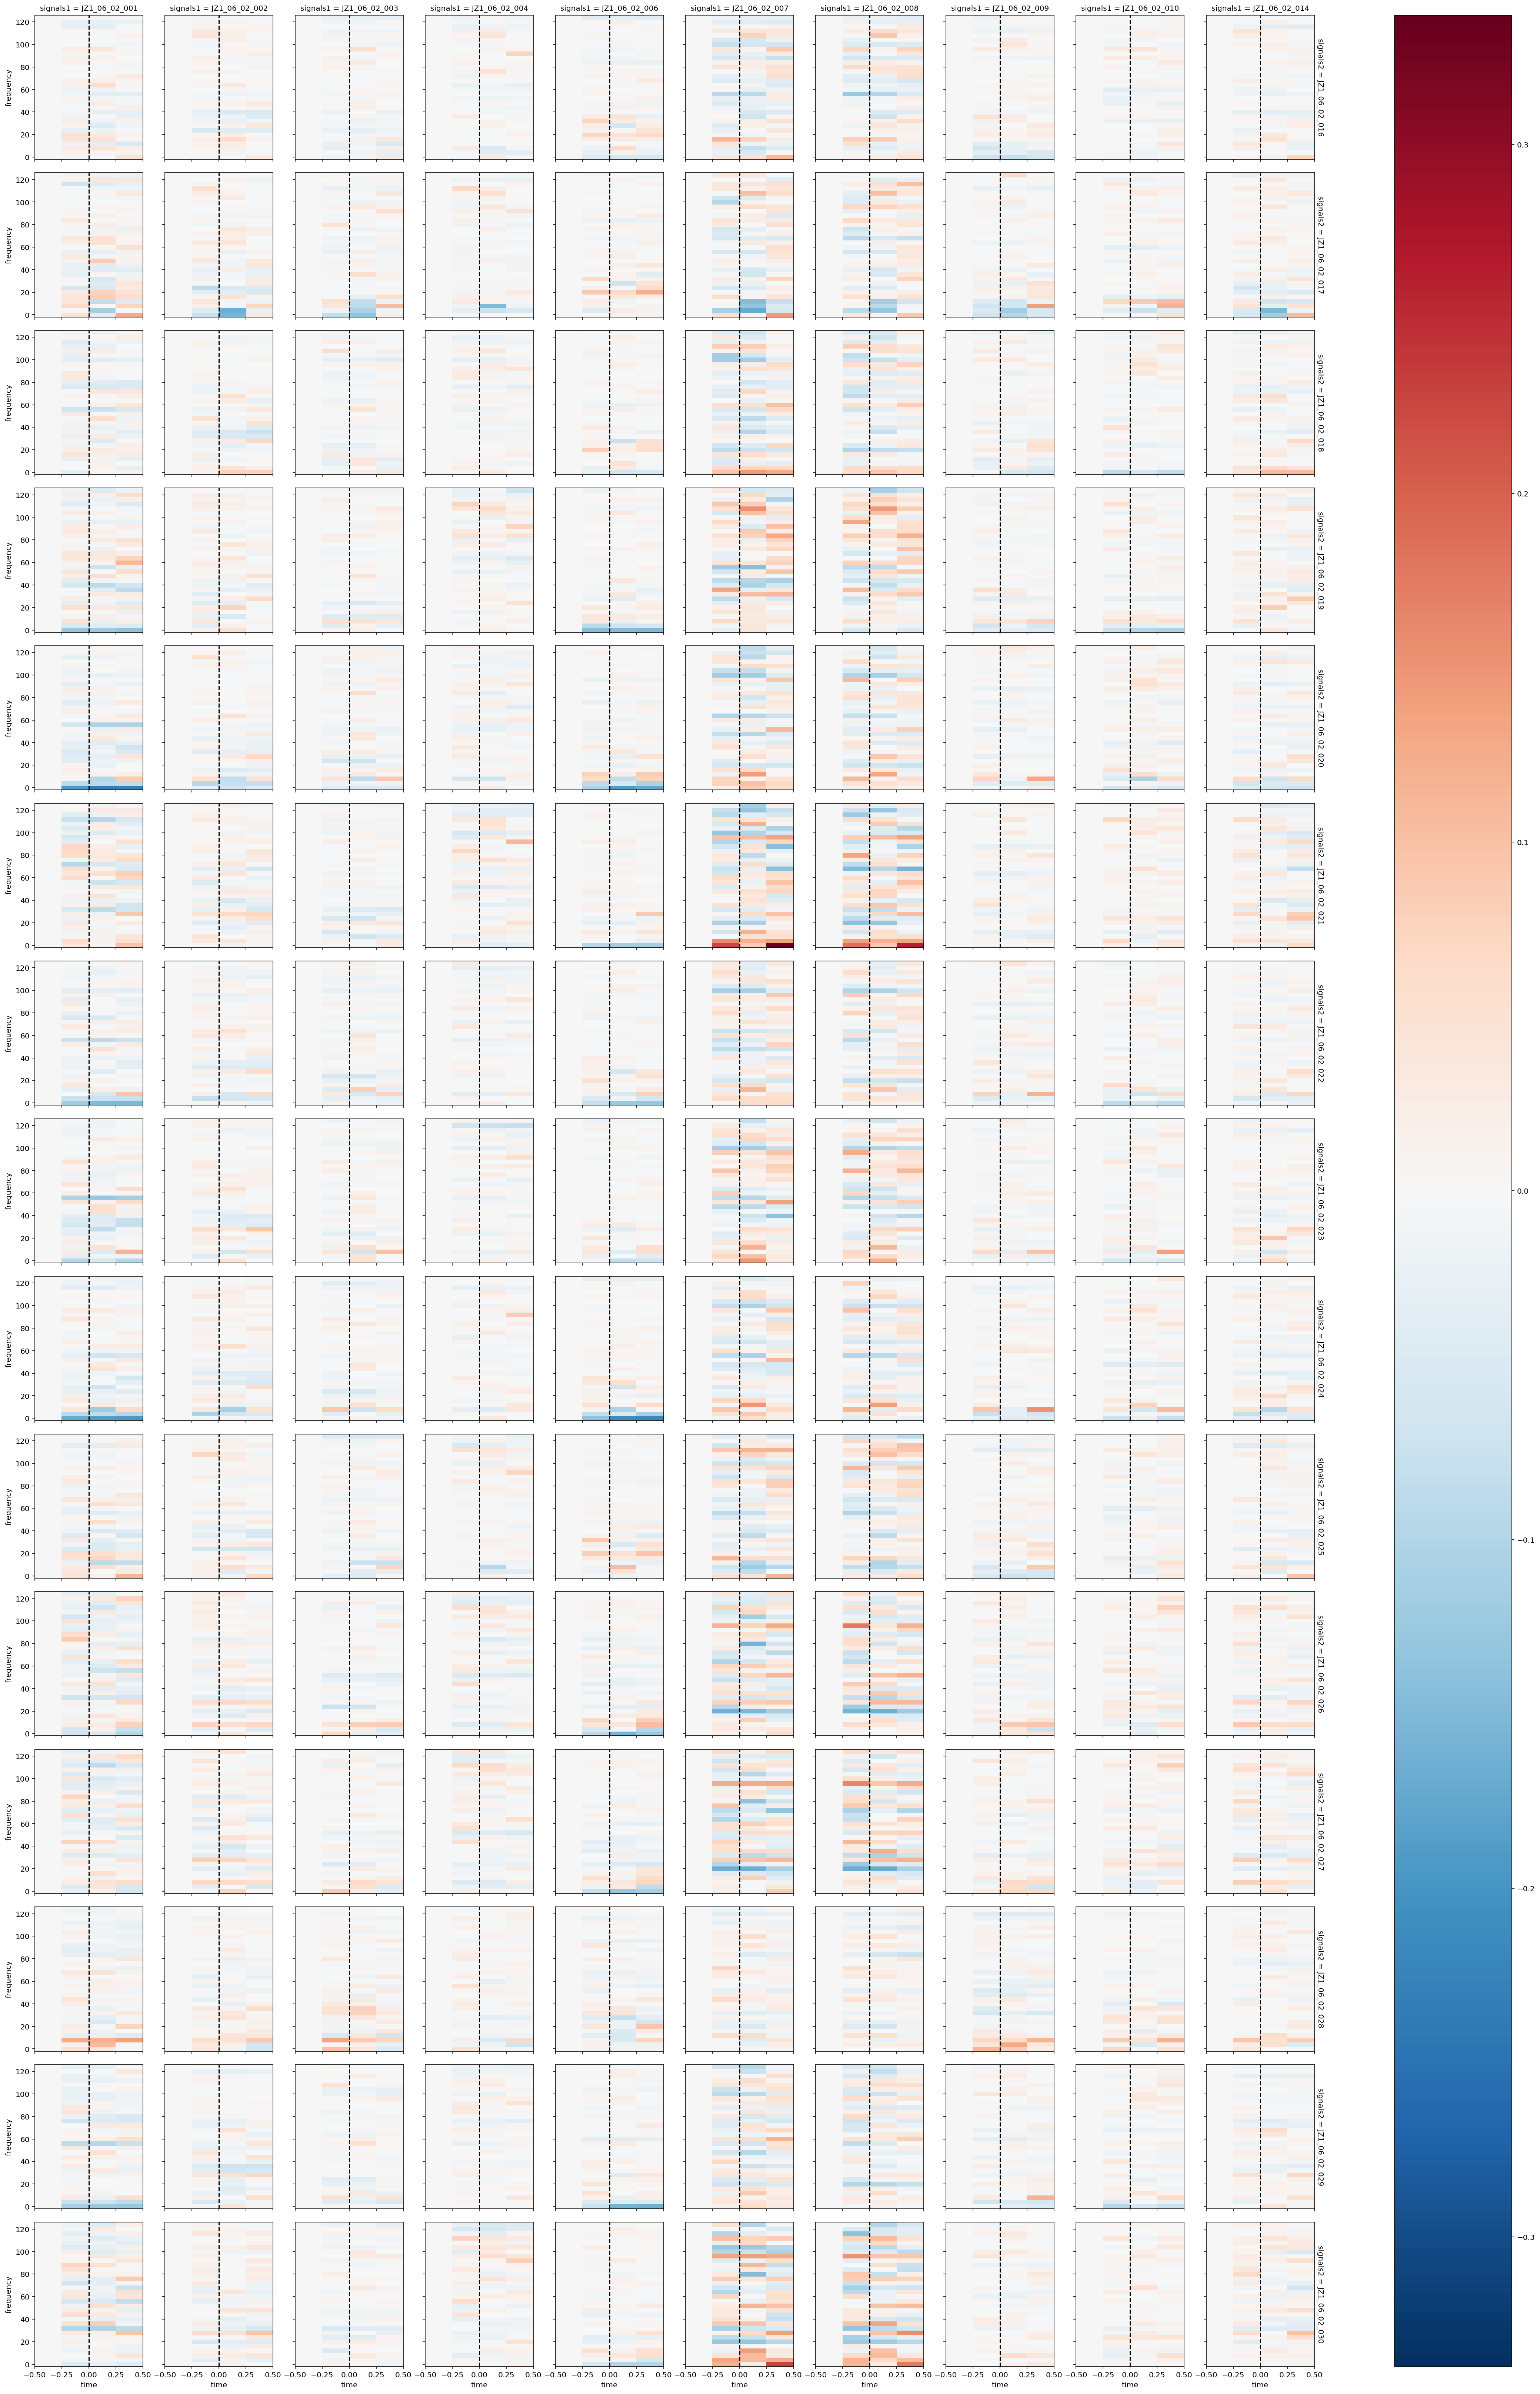

In [15]:
plot_coherence(ripple_locked_LFPs, LFPs, window_offset, _4Hz_Res, slice(0, 125), tetrode_info)

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=1,
           time_window_duration=0.5, time_window_step=0.5,
           detrend_type='constant', start_time=-0.5, n_tapers=1)


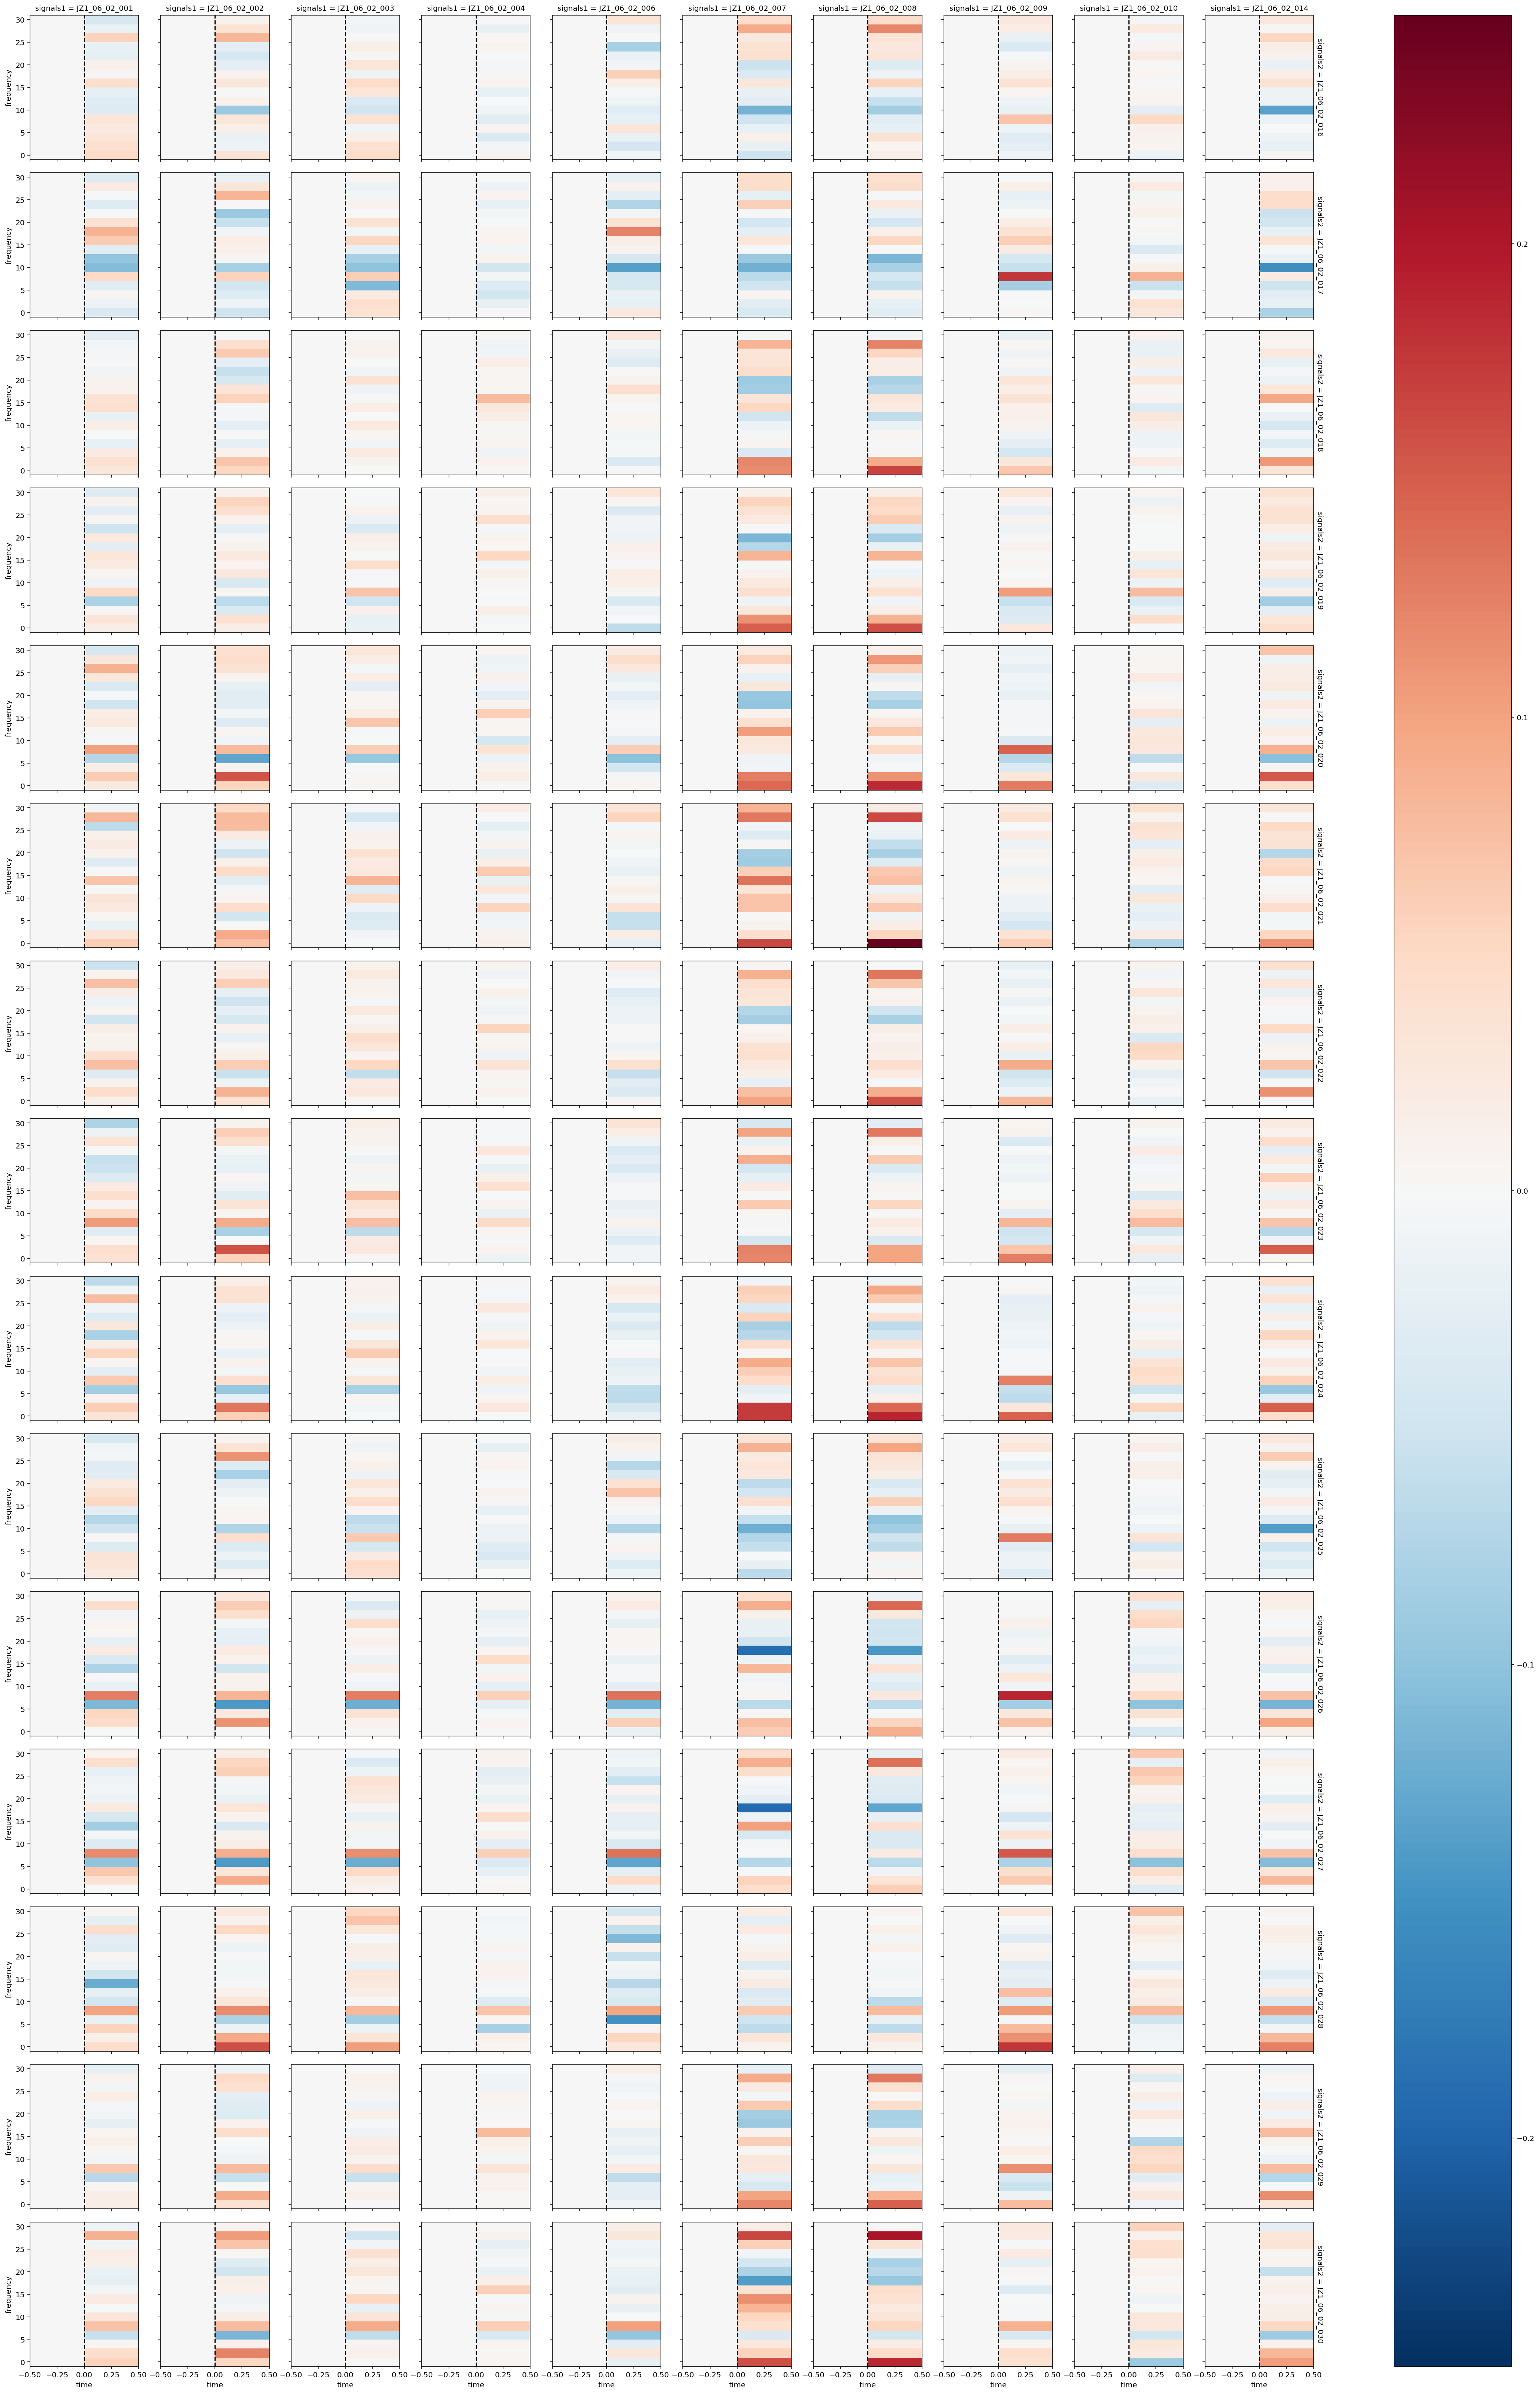

In [16]:
plot_coherence(ripple_locked_LFPs, LFPs, window_offset, _2Hz_Res, slice(0, 30), tetrode_info)

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=3,
           time_window_duration=0.1, time_window_step=0.1,
           detrend_type='constant', start_time=-0.5, n_tapers=5)


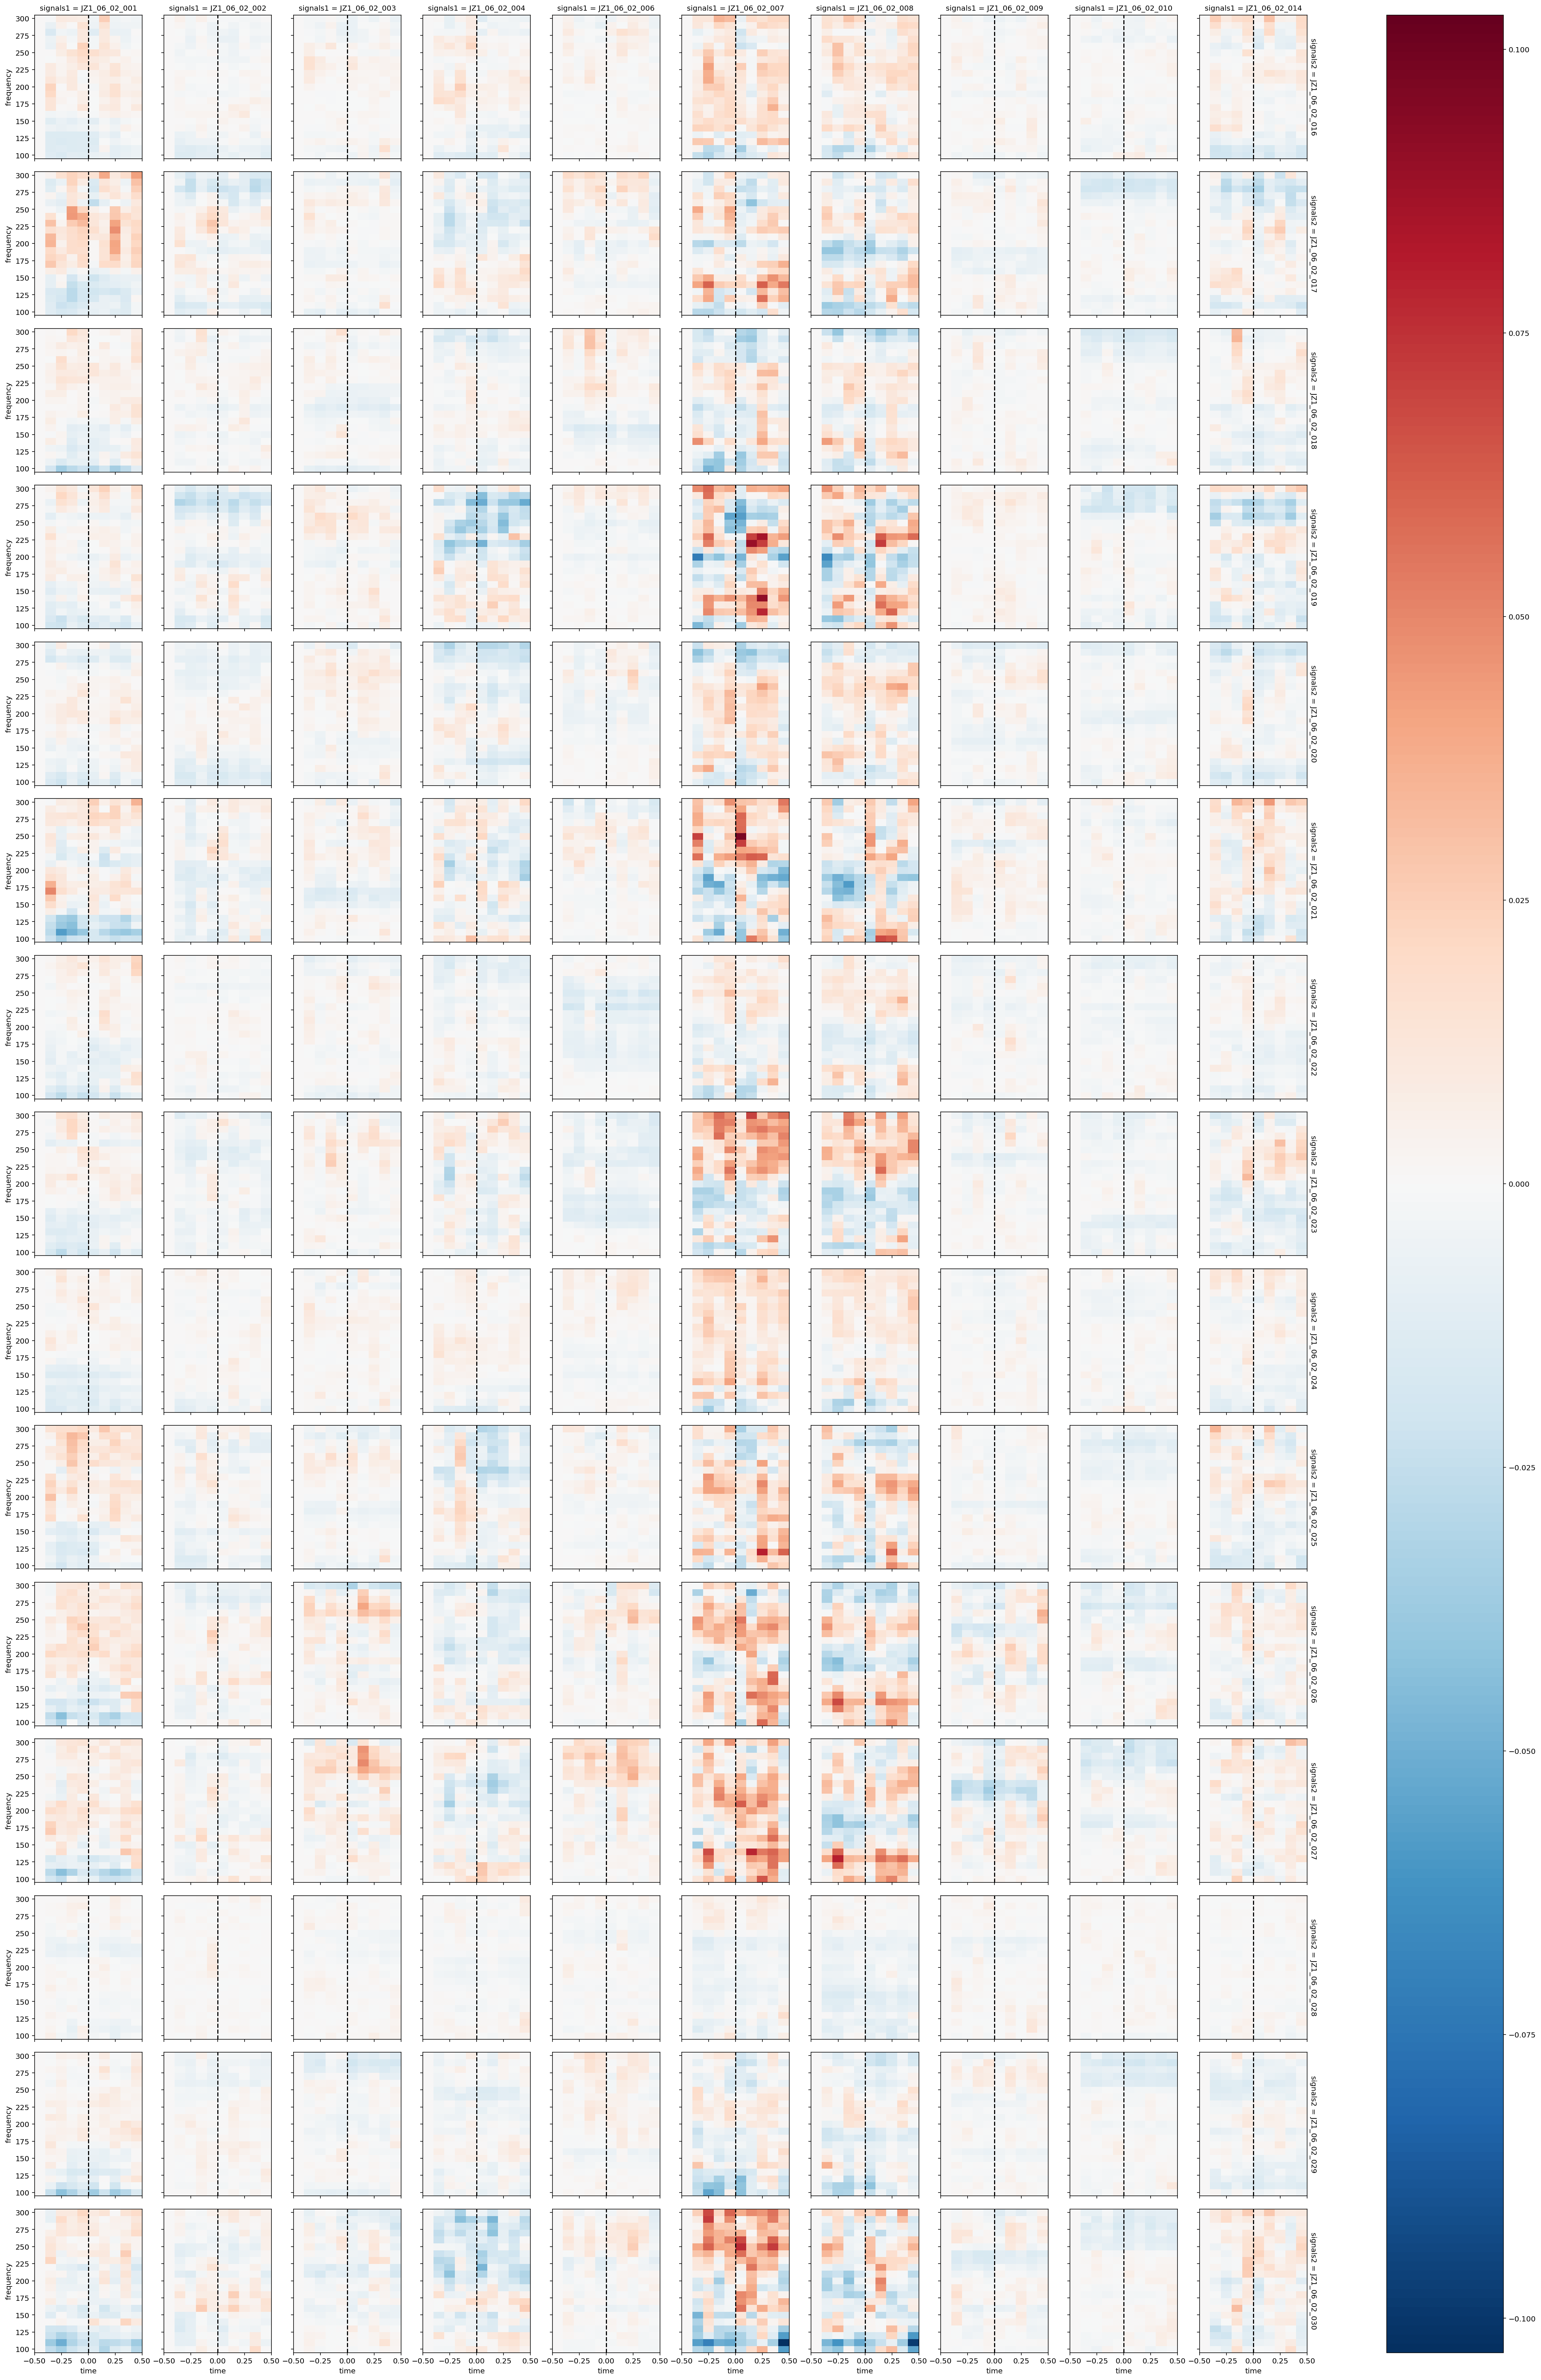

In [17]:
plot_coherence(ripple_locked_LFPs, LFPs, window_offset, _20Hz_Res, slice(100, 300), tetrode_info)

In [18]:
m = spectral_connectivity.Multitaper(
    ripple_locked_LFPs.values, **_10Hz_Res, start_time=window_offset[0])
c = spectral_connectivity.Connectivity.from_multitaper(m)
canonical_coherence, area_labels = c.canonical_coherence(
    tetrode_info.area.tolist())
dimension_names = ['time', 'frequency', 'brain_area1', 'brain_area2']
data_vars = {
    'canonical_coherence': (dimension_names, canonical_coherence)}
coordinates = {
    'time': c.time + np.diff(c.time)[0] / 2,
    'frequency': c.frequencies,
    'brain_area1': area_labels,
    'brain_area2': area_labels,
}

canonical_coherence = xr.Dataset(data_vars, coords=coordinates)
canonical_coherence

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=1,
           time_window_duration=0.1, time_window_step=0.1,
           detrend_type='constant', start_time=-0.5, n_tapers=1)


<xarray.Dataset>
Dimensions:              (brain_area1: 5, brain_area2: 5, frequency: 50, time: 10)
Coordinates:
  * time                 (time) float64 -0.45 -0.35 -0.25 -0.15 -0.05 0.05 ...
  * frequency            (frequency) float64 0.0 10.0 20.0 30.0 40.0 50.0 ...
  * brain_area1          (brain_area1) <U3 'ca1' 'mec' 'por' 'sub' 'v2l'
  * brain_area2          (brain_area2) <U3 'ca1' 'mec' 'por' 'sub' 'v2l'
Data variables:
    canonical_coherence  (time, frequency, brain_area1, brain_area2) float64 nan ...

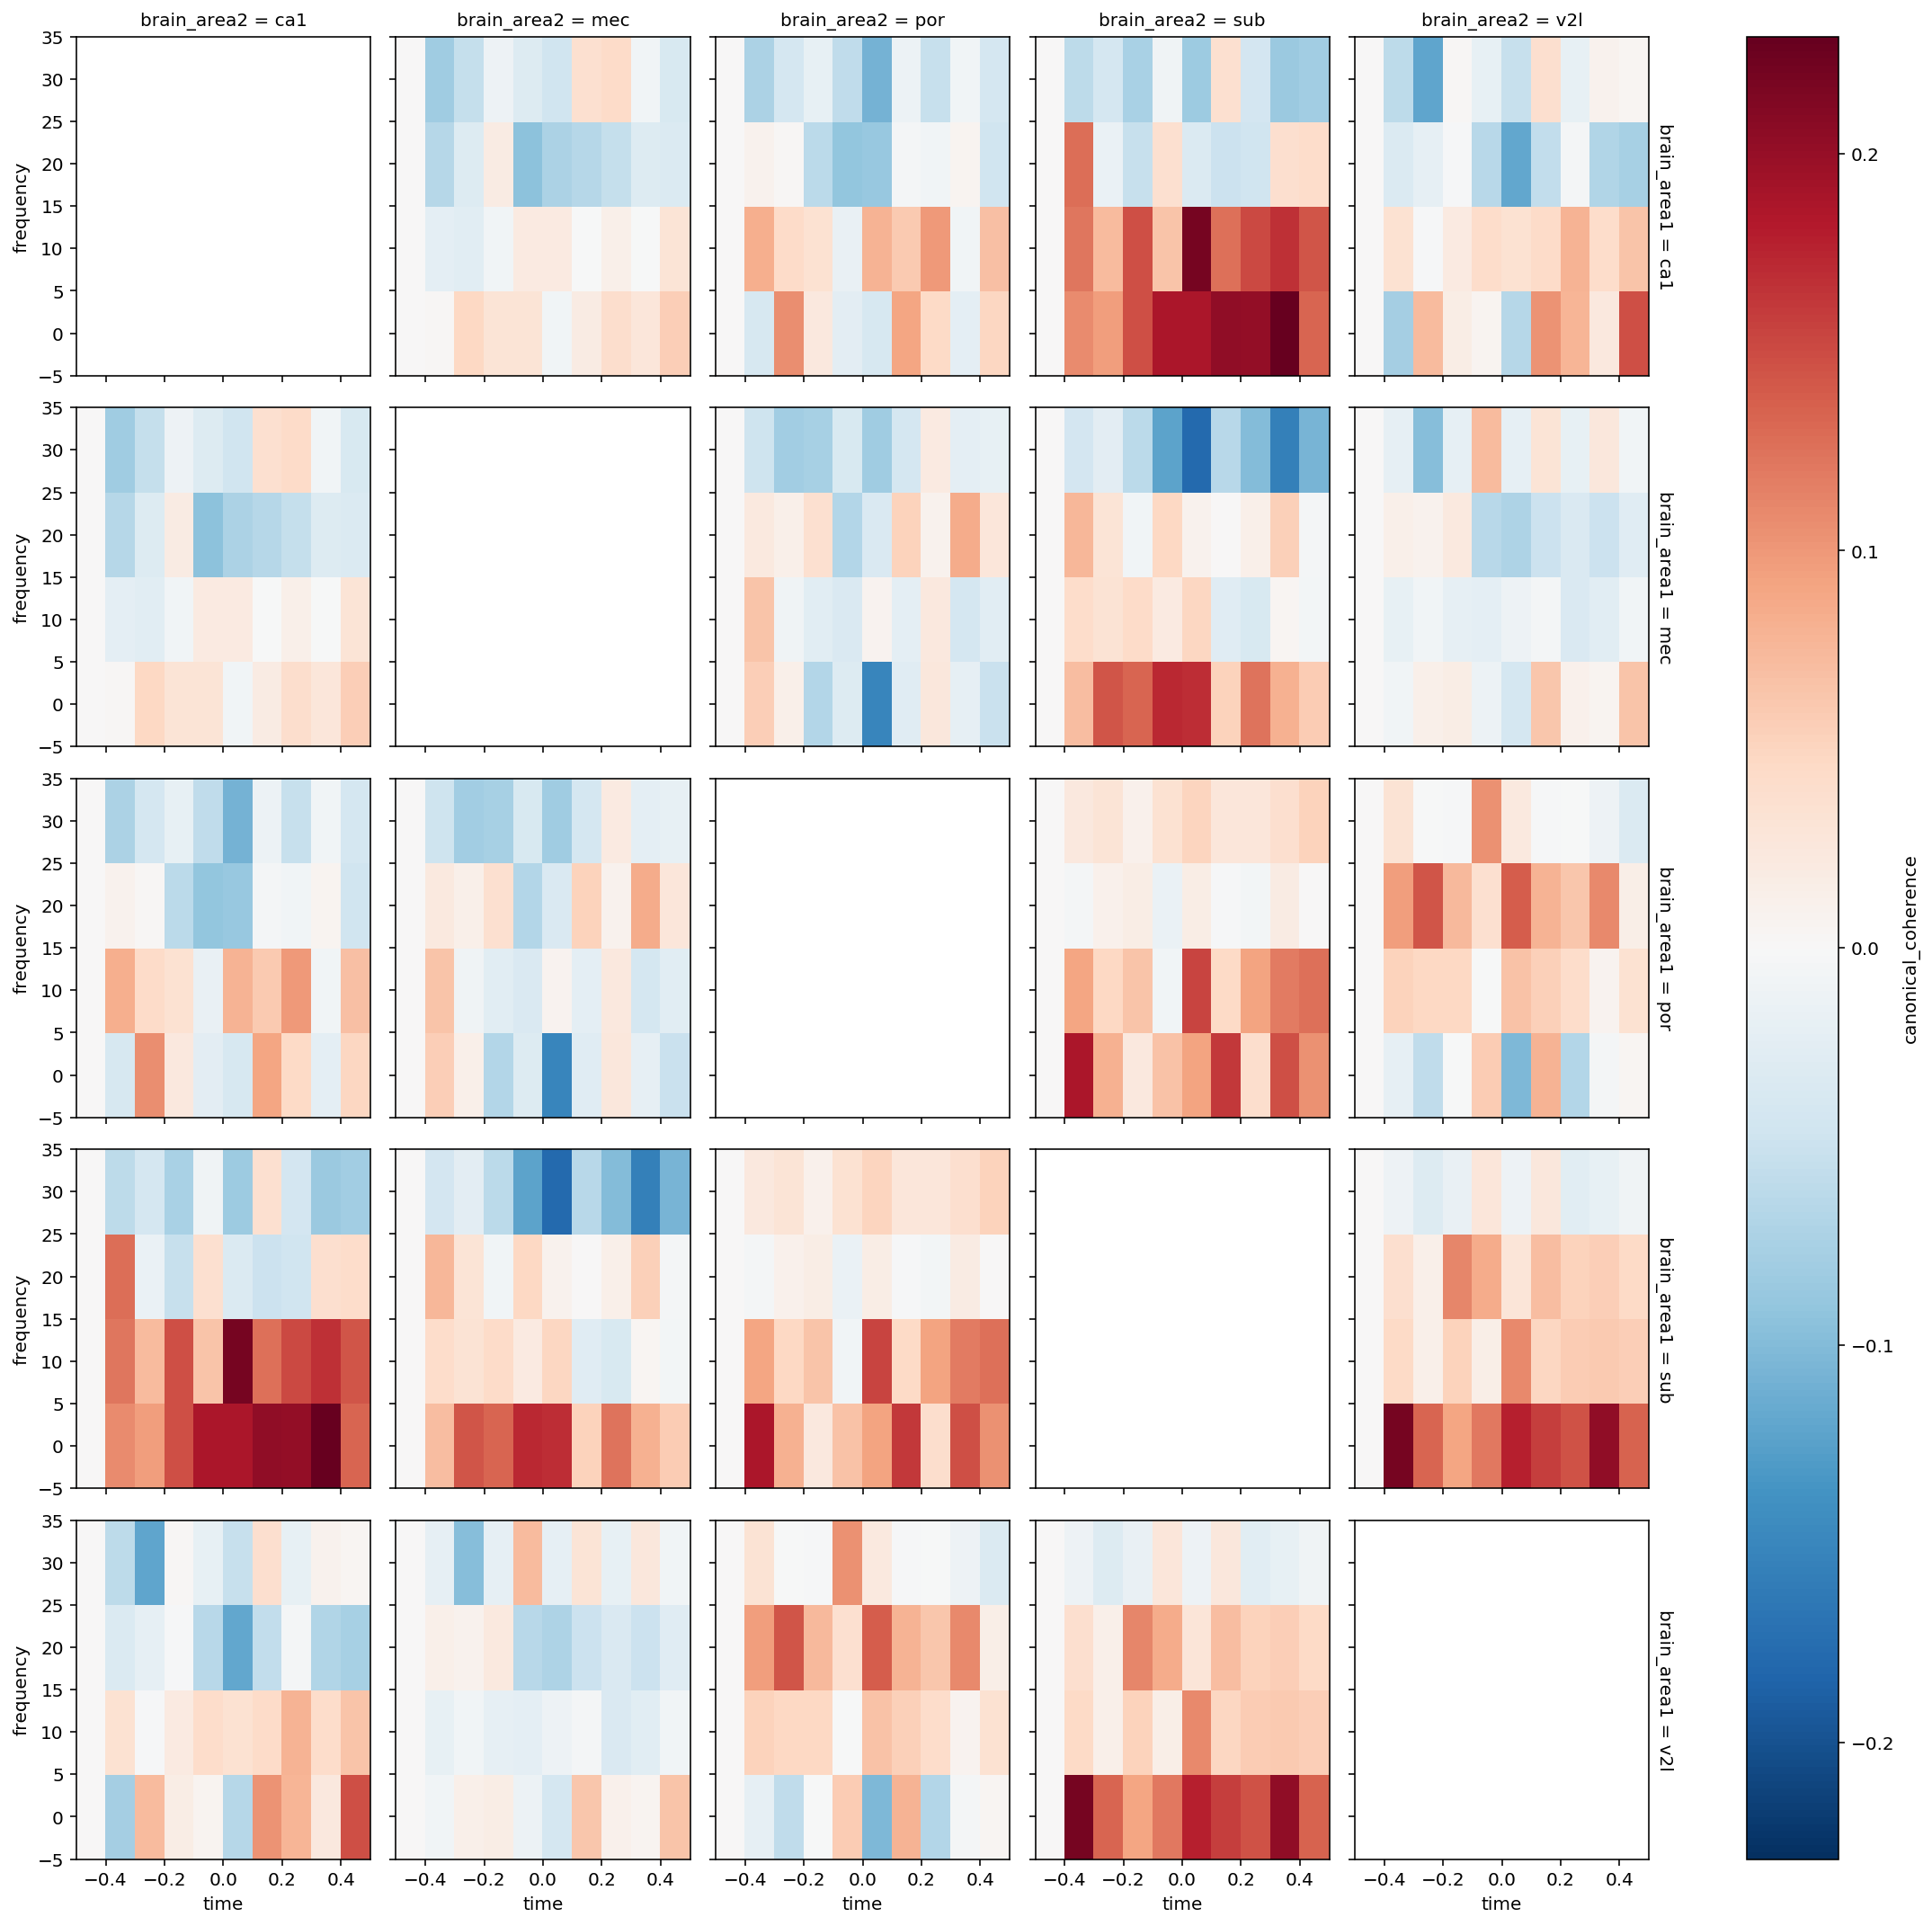

In [19]:
(canonical_coherence - canonical_coherence.isel(time=0)).sel(frequency=slice(0, 30)).canonical_coherence.plot(
    x='time', y='frequency', row='brain_area1', col='brain_area2')

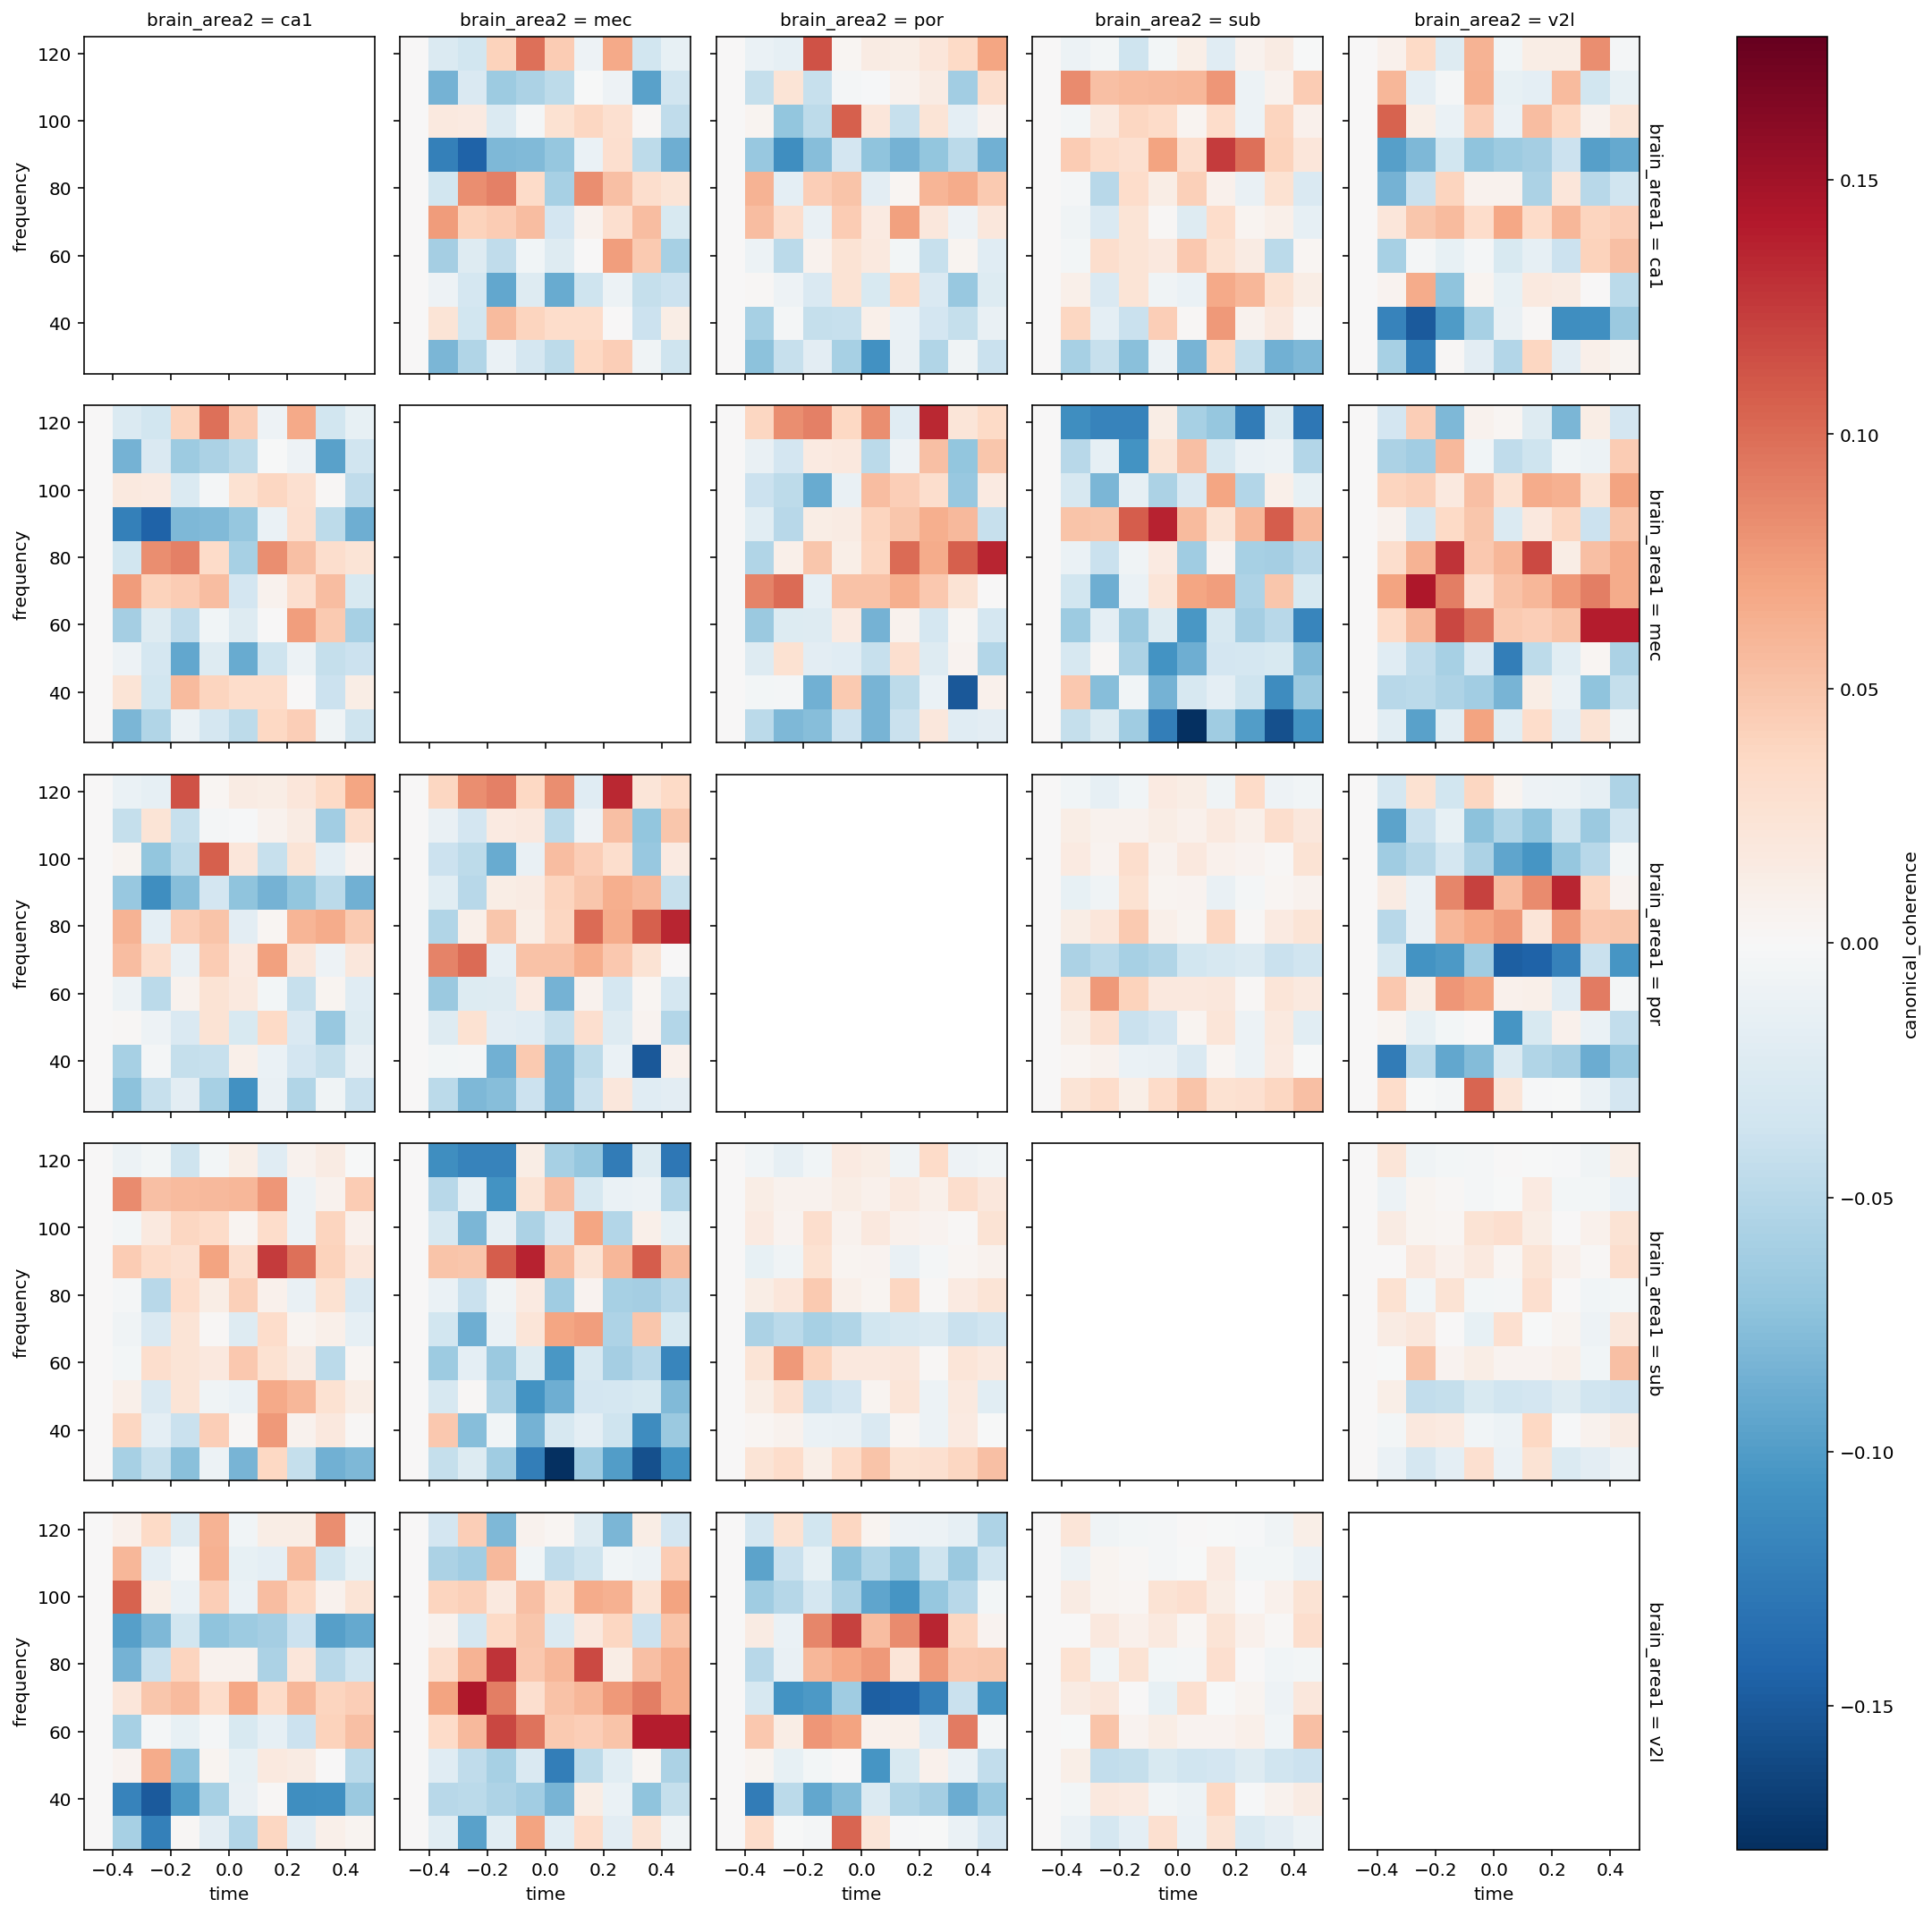

In [20]:
(canonical_coherence - canonical_coherence.isel(time=0)).sel(frequency=slice(30, 125)).canonical_coherence.plot(
    x='time', y='frequency', row='brain_area1', col='brain_area2')

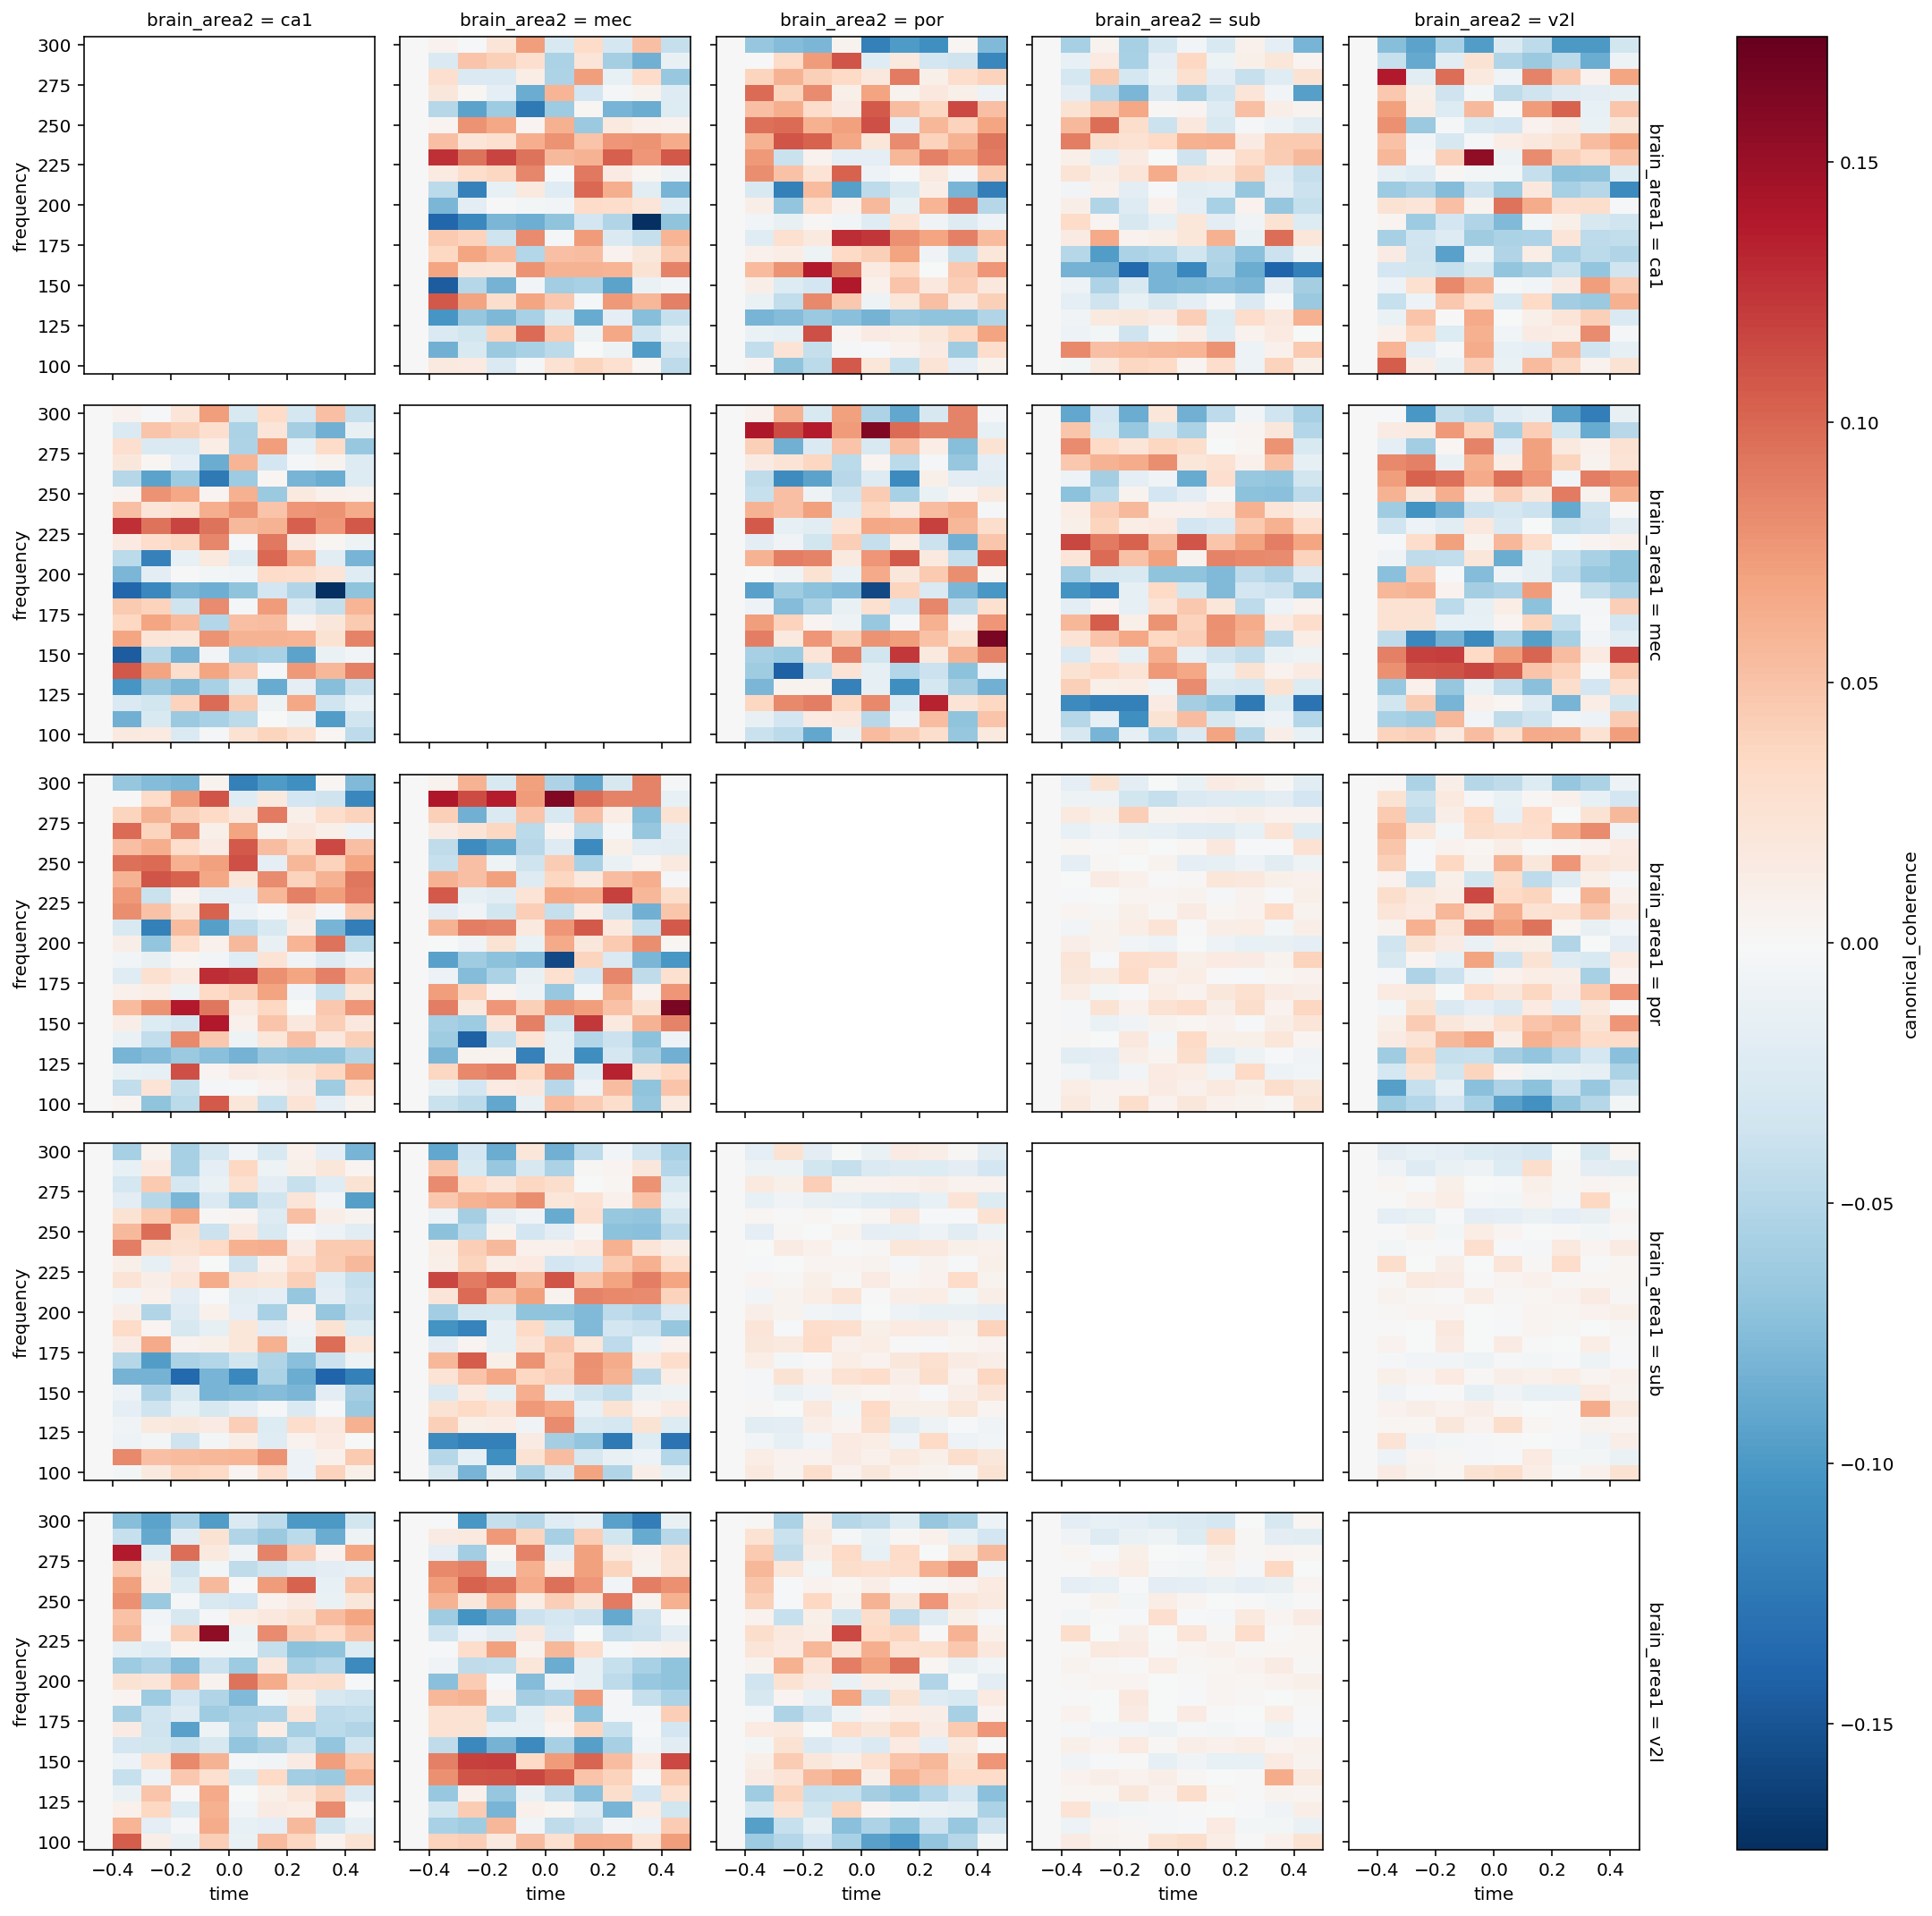

In [21]:
(canonical_coherence - canonical_coherence.isel(time=0)).sel(frequency=slice(100, 300)).canonical_coherence.plot(
    x='time', y='frequency', row='brain_area1', col='brain_area2')